# ADM - HW4 - Getting to know your customers

## Libraries & Setup

In [2]:
import pandas as pd   # Data manipulation and analysis
import numpy as np    # Scientific Computing
from random import sample   # Random Sampling
import heapq   # Heap data structure
import matplotlib.pyplot as plt   # Visualization

from sklearn.metrics import silhouette_score   # Clustering analysis
from sklearn.cluster import KMeans   # Clustering analysis

import sklearn
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

import functions

# 1. Finding Similar Costumers

## 1.1 Set up the data

In [3]:
data = pd.read_csv("bank_transactions.csv")

The missing values of the columns `CustGender` (1100), `CustLocation` (151) and `CustAccountBalance` (2369) are dropped, as they don't even represent 0.7% of the total data. Regarding `CustomerDOB` missing values, <b>apart from the original 3,397 NaNs, there are also 57,339 values whose Customer is born in "1800-01-01", so we consider those as missing values too</b>, representing nearly 6% of total data (60.736 rows). Therefore, we will impute them by looking at their "nearest neighbours". But this will be done after <b>creating a new costumer ID, as it is explained below.

In [4]:
#Drop NaNs from: CustGender, CustLocation and CustAccountBalance
data = data.dropna(subset=['CustGender', 'CustLocation',"CustAccountBalance"])

#CustomerDOB: NaNs and dates that are "1800-01-01" are replaced by "0", in order to group them as missing values.(we don't set them to NaNs because interferes with the process of creating a new costumer ID)
data.fillna(0,inplace = True)
data = data.replace({"CustomerDOB":{'1/1/1800':0}})

#But before continuing dealing wit CustomerDOB NaNs, we need to create a new customer ID.

### New Costumer ID

After exploring the data we noticed that transactions of the same `CustomerID` rarely share a common `CustomerDOB`, `CustGender`, `CustAccountBalance`, or `CustLocation`, which doesn't make any sense. Moreover, after reading discussions about this matter (on slack), we concluded that current IDs could be ignored. Therefore, we <b>created new costumer IDs</b>, in such a way that: <b>if a set of transactions contain the exact same `CustomerDOB`, `CustGender` and `CustAccountBalance` we assign to those transactions the same (new) "ID". In this way we get, what seem to be the "real customers"</b>. Moreover, we believe that these are most likely not individuals but rather other bank's branches (which might be the reason why they maintain almost always the same location). Under this assumption, the number of unique customers (IDs) have reduced from 885K to nearly 171K, meaning that this "grouping pattern" clearly fits all the data, otherwise we wouldn't see such a difference.

In [5]:
#We create a dict. with all different combinations of Gender, DOB and Account Balance seen in the data (as keys)
#and assigning them a unique __id__ (values).

ID = {}
_id_ = 0
for index, row in data.iterrows():
    if (row['CustomerDOB'], row['CustGender'], row['CustAccountBalance']) not in ID:
        ID[row['CustomerDOB'], row['CustGender'], row['CustAccountBalance']] = _id_
        _id_ += 1
data['ID'] = data.apply(lambda x: ID[x['CustomerDOB'], x['CustGender'], x['CustAccountBalance']], axis=1)
data['ID'] = data['ID'].astype(int)

#We can observe the output of the new ID
data[data.ID== 4]

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),ID
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.50,4
74405,T74406,C6731212,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,182857,520.00,4
75391,T75392,C1231213,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,183125,427.00,4
83337,T83338,C8731271,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,205943,3715.04,4


### Missing values

By exploring the rows with missing values and grouping them together in different ways we found out that a lot of the rows were nearly identical among them, meaning that they were transactions made by the same customer. <b>At the end, instead of dropping 60K rows, we identified 9500 new unique customers and assigned to each one of them, the same randomly sampled date (from `CustomerDOB` distribution) in all their transactions.

In [6]:
#This is an example of 4 transactions with NaNs in CustomerDOB, that have been grouped by the new ID
data[data.ID== 16]

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),ID
16,T17,C1376215,0,M,MUMBAI,77495.15,1/8/16,124727,1423.11,16
894043,T894044,C5376228,0,M,MUMBAI,77495.15,7/9/16,124454,17117.05,16
894825,T894826,C5976222,0,M,MUMBAI,77495.15,7/9/16,125158,6085.00,16
896127,T896128,C1576214,0,M,MUMBAI,77495.15,7/9/16,125602,1650.00,16


The next step is to make sure that, all the transactions that belong to the same customer, are assigned with the same randomly sampled date from the `CustomerDOB` distribution.

In [7]:
#We create a new DF containing all rows with CustomerDOB NaNs or containing "1800-01-01".
missing_values_df = data[data.CustomerDOB == 0]
#We drop these 60K rows from the data, we will concat them later with the NaN values filled in.
data = data.drop(data[data.CustomerDOB == 0].index ,axis = 0)

#We create a dictionary to map every new ID with a randomly sampled date from the CustomerDOB column.
missing_values_df["New_Date"]= missing_values_df.ID
new_dates = pd.DataFrame(sample(list(data.CustomerDOB),8979),np.unique(missing_values_df.ID)).to_dict()[0]
missing_values_df = missing_values_df.replace({"New_Date":new_dates})

#Some adjustments before concatenating again with the data
missing_values_df["CustomerDOB"] = missing_values_df["New_Date"]
missing_values_df.drop("New_Date", axis = 1, inplace = True)

#We update the data with the 60K that were dropped, but now without NaNs.
data = pd.concat([data,missing_values_df])

#We can observe that the same randomly sampled date has been assigned to all transactions of this costumer
data[data.ID== 16]

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),ID
16,T17,C1376215,6/12/92,M,MUMBAI,77495.15,1/8/16,124727,1423.11,16
894043,T894044,C5376228,6/12/92,M,MUMBAI,77495.15,7/9/16,124454,17117.05,16
894825,T894826,C5976222,6/12/92,M,MUMBAI,77495.15,7/9/16,125158,6085.00,16
896127,T896128,C1576214,6/12/92,M,MUMBAI,77495.15,7/9/16,125602,1650.00,16


In [8]:
#Finally we remove the current CustomerID
data["CustomerID"] =  data["ID"]
data.drop("ID", axis = 1, inplace = True)
#And reset the index of the dataframe
data = data.reset_index().drop("index", axis = 1)

###  Data Cleaning

#### CustomerDOB

In order to <b>fix the Millennium bug</b>, we subtract 100 years to those values above 2016. Those are the only values that "for sure" are wrong. Also, is not very likely that people from more than 100 years old do transactions on 2016, that's why we apply the millennium bug correction from 2016 (and not 2000).

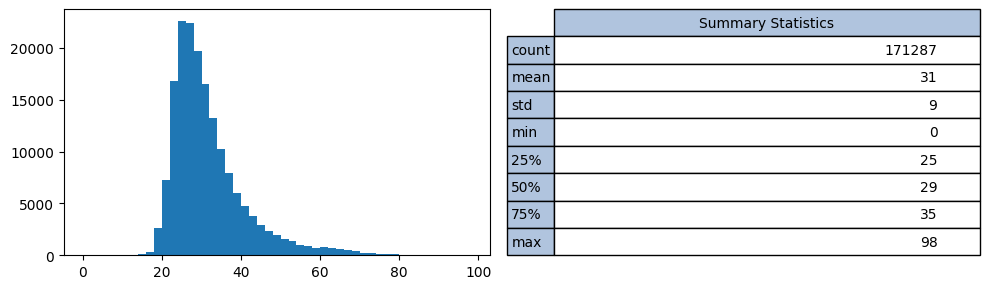

In [9]:
#CONVERT TO DATETIME OBJECT
data.CustomerDOB =  pd.to_datetime(data.CustomerDOB)
#FIXING MILLENNIUM BUG
data.drop(data[data.CustomerDOB == "1800-01-01"].index, axis = 0,inplace = True)
data.loc[data.CustomerDOB.dt.year > 2016, "CustomerDOB"] -= pd.offsets.DateOffset(years = 100)
#CREATE "AGE", WHICH IS MORE CONVENIENT
data["CustomerAge"] = ((pd.to_datetime("20160101", format = "%Y%m%d", errors = "ignore" ) - data.CustomerDOB) / np.timedelta64(1,"Y")).round()
data["CustomerAge"] = data["CustomerAge"].astype(int)
#REPLACE CustomerDOB by CustomerAGE
cols = data.columns.tolist()
cols = cols[0:2] + cols[-1:] + cols[3:-1]
data = data[cols]
#PLOT AGE DISTRIBUTION BY COSTUMER ID
functions.distribution_summary_hist(data.groupby("CustomerID").CustomerAge.mean(), data.groupby("CustomerID").CustomerAge.mean() , 49)

#### CustGender

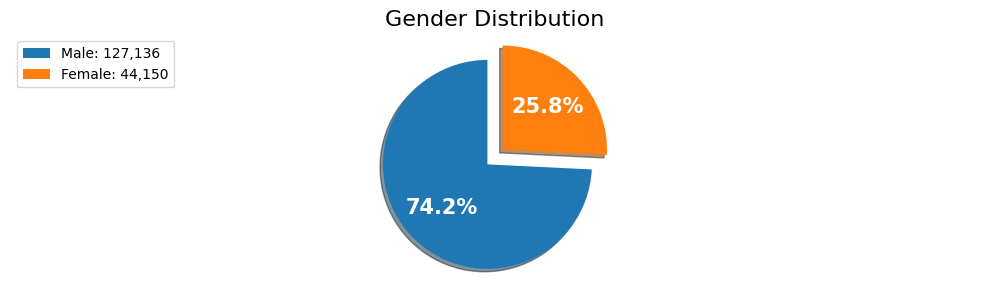

In [10]:
#PLOT GENDER DISTRIBUTION BY COSTUMER ID
functions.pie_chart(data.groupby("CustomerID").CustGender.last().value_counts().values[0:2] , ["Male: 127,136","Female: 44,150"] , "Gender Distribution")

#### CustLocation

These are the 20 most frequent cities, in which live  58.89 % of customers appearing in the dataset.


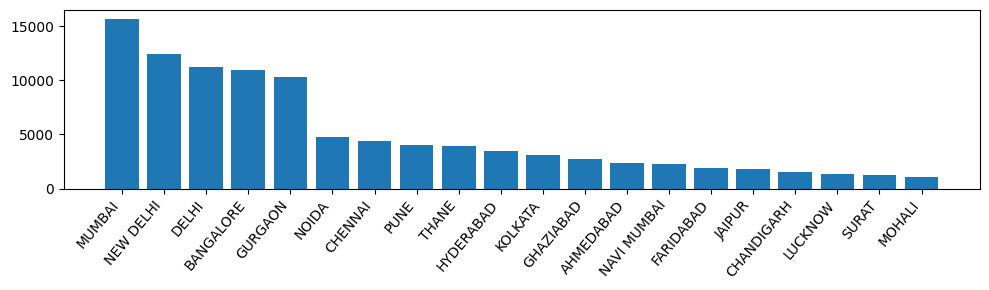

In [11]:
#PLOT CUSTOMER DISTRIBUTION BY COSTUMER ID
plt.bar(data.groupby("CustomerID").CustLocation.last().value_counts()[0:20].index, data.groupby("CustomerID").CustLocation.last().value_counts()[0:20].values) , plt.xticks(rotation=50 , ha='right')
print("These are the 20 most frequent cities, in which live ",round(sum(data.groupby("CustomerID").CustLocation.last().value_counts()[0:20])/len(np.unique(data.CustomerID))*100,2),"% of customers appearing in the dataset.")
plt.show()

#### CustAccountBalance

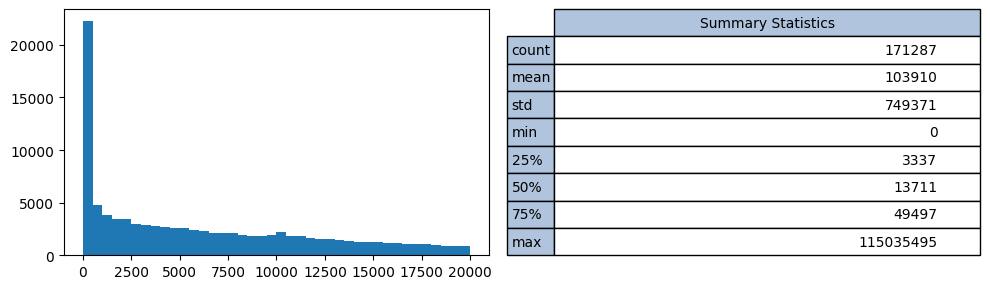

In [12]:
#PLOT ZOOMING IN THOSE ACCOUNTS WITH LESS THAN 20,000 INR (BETWEEN 50% AND 75% OF THE CUSTOMERS).
data['CustAccountBalance'] = data['CustAccountBalance'].astype(int)
functions.distribution_summary_hist(data.groupby("CustomerID").CustAccountBalance.last(), data.groupby("CustomerID").CustAccountBalance.last()[data.groupby("CustomerID").CustAccountBalance.last() < 20000] , 40)

#### TransactionAmount (INR)

We get rid of the cents, and change the name for TransactionAmount for convenience.

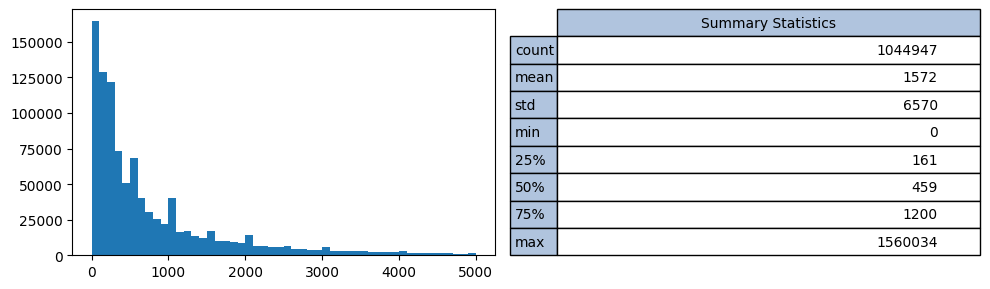

In [13]:
data['TransactionAmount (INR)'] = data['TransactionAmount (INR)'].astype(int)
data.rename({'TransactionAmount (INR)': 'TransactionAmount'}, axis=1 , inplace = True)
#WE PLOT THE DISTRIBUTION OF TRANSACTION AMOUNTS < 5,000 INR, WHICH ARE MORE THAN 75% OF TRANSACTIONS.
functions.distribution_summary_hist(data.TransactionAmount, data['TransactionAmount'][data['TransactionAmount'] < 5000] , 50)

#### TransactionDate and TransactionTime

We create a new column that is TransactionDateTime, and another column TransactionHour. Also, we convert the times into a proper format (Hour:Minute:Second)

In [14]:
data.TransactionTime = data.TransactionTime.apply(lambda x: datetime.strptime(str(x).zfill(6), '%H%M%S')).dt.time.astype(str)
data["TransactionDateTime"] = pd.to_datetime(data['TransactionDate'] + ' ' + data['TransactionTime'])
data["TransactionHour"] = pd.to_datetime(data.TransactionTime, format='%H:%M:%S').dt.hour
data.TransactionTime = pd.to_datetime(data.TransactionTime, format='%H:%M:%S').dt.time
data.TransactionDate = pd.to_datetime(pd.to_datetime(data.TransactionDate).dt.date)

In [19]:
df = data.groupby("CustomerID").mean().drop("TransactionHour",axis = 1).astype(int).reset_index()
df.rename({'TransactionAmount': 'TransactionAmountAverage'}, axis=1, inplace = True)

In [20]:
df.head(10)

,CustomerID,CustomerAge,CustAccountBalance,TransactionAmountAverage
0,0,21,17819,80
1,1,59,2270,9503
2,2,19,17874,940
3,3,42,866503,2537
4,4,28,6714,1606
5,5,43,53609,1418
6,6,24,973,1527
7,7,34,95075,649
8,8,28,14906,11751
9,9,32,4279,510


## 1.2 Fingerprint hashing

Our version of the *LSH algorithm* describes each customer according to three features we believe a bank would take into account when comparing different clients: **age**, **account balance** and **average transaction amount** (over all the customer transaction in the input dataset).

We proceed by implementing the *MinHash* and *LSH* algorithms from scratch. For the *shingling* step, the three input features are **discretized** into *bins*, whose number and size is chosen in an attempt to match the *data distribution* (in order to have a **balanced** allocation of input feature values among bins), while providing insights *relevant* for the purpose of our analysis.

In [21]:
# Define bins and corresponding shingles
age_bins = [22, 25, 29, 35, 45]
acc_balance_bins = [2.5*1e2, 2*1e3, 5*1e3, 1e4, 1.5*1e4, 2.5*1e4, 5*1e4, 1e5, 3*1e5, 6*1e5, 1e6, 5*1e6, 1e7]
avg_transaction_bins = [1.5*1e2, 3*1e2, 5*1e2, 7.5*1e2, 1e3, 1.5*1e3, 2.5*1e3, 7.5*1e3, 3*1e4]

**Age** shingles: *"A<=22", "23<=A<=25", "26<=A<=29", "30<=A<=35", "36<=A<=45", "A>=46"*

In [ ]:
age_shingles = ["A<=22", "23<=A<=25", "26<=A<=29", "30<=A<=35", "36<=A<=45", "A>=46"]

**Account balance** shingles: *"B<=250", "250<B<=2K", "2K<B<=5K", "5K<B<=10K", "10K<B<=15K", "15K<B<=25K", "25K<B<=50K", "50K<B<=100K", "100K<B<=300K", "300K<B<=600K", "600K<B<=1M", "1M<B<=5M", "5M<B<=10M", "B>=10M"*

In [ ]:
acc_balance_shingles = ["B<=250", "250<B<=2K", "2K<B<=5K", "5K<B<=10K", "10K<B<=15K", "15K<B<=25K", "25K<B<=50K", "50K<B<=100K", "100K<B<=300K", "300K<B<=600K", "600K<B<=1M", "1M<B<=5M", "5M<B<=10M", "B>=10M"]

**Average transaction amount** shingles: *"T<=150", "150<T<=300", "300<T<=500", "500<T<=750", "750<T<=1K", "1K<T<=1.5K", "1.5K<T<=2.5K", "2.5K<T<=7.5K", "7.5K<T<=30K", "T>=30k"*

In [ ]:
avg_transaction_shingles = ["T<=150", "150<T<=300", "300<T<=500", "500<T<=750", "750<T<=1K", "1K<T<=1.5K", "1.5K<T<=2.5K", "2.5K<T<=7.5K", "7.5K<T<=30K", "T>=30k"]

In [22]:
shingles = set(age_shingles+acc_balance_shingles+avg_transaction_shingles)

# Map between shingles and unique shingle ids
shingles_id = {b: a for a, b in enumerate(shingles)}

In [23]:
shingles_id

{'26<=A<=29': 0,
 'A>=46': 1,
 '100K<B<=300K': 2,
 '600K<B<=1M': 3,
 '500<T<=750': 4,
 '150<T<=300': 5,
 '1K<T<=1.5K': 6,
 'A<=22': 7,
 '30<=A<=35': 8,
 '25K<B<=50K': 9,
 '5K<B<=10K': 10,
 '300<T<=500': 11,
 '10K<B<=15K': 12,
 '23<=A<=25': 13,
 '1.5K<T<=2.5K': 14,
 '2K<B<=5K': 15,
 '750<T<=1K': 16,
 '250<B<=2K': 17,
 'B>=10M': 18,
 'T<=150': 19,
 'T>=30k': 20,
 '1M<B<=5M': 21,
 '15K<B<=25K': 22,
 '36<=A<=45': 23,
 'B<=250': 24,
 '50K<B<=100K': 25,
 '300K<B<=600K': 26,
 '2.5K<T<=7.5K': 27,
 '7.5K<T<=30K': 28,
 '5M<B<=10M': 29}

In [24]:
# Customers shingling function
def shingling(df, shingles, shingles_id):

    shingle_matrix = {}
    shingle_sets = {}

    # Process dataframe as list of dicts of individual customers
    data = df.to_dict(orient='records')

    for record in data:

        shingle_sets[record["CustomerID"]] = set()

        # For each customer, check the bin to which each feature values belong, retrieve corresponding shingles, edit the customer row and add it to the shingle matrix

        row = [0]*len(shingles)

        # np.digitize: returns index i satisfying bins[i-1] < x <= bins[i] for each element in input

        # Age
        bin = np.digitize([record["CustomerAge"]], age_bins, right=True)[0]
        shingle = age_shingles[bin]
        shingle_id = shingles_id[shingle]
        row[shingle_id]=1
        shingle_sets[record["CustomerID"]].add(shingle)

        # Account Balance
        bin = np.digitize([record["CustAccountBalance"]], acc_balance_bins, right=True)[0]
        shingle = acc_balance_shingles[bin]
        shingle_id = shingles_id[shingle]
        row[shingle_id]=1
        shingle_sets[record["CustomerID"]].add(shingle)

        # Average Transaction Amount
        bin = np.digitize([record["TransactionAmountAverage"]], avg_transaction_bins, right=True)[0]
        shingle = avg_transaction_shingles[bin]
        shingle_id = shingles_id[shingle]
        row[shingle_id]=1
        shingle_sets[record["CustomerID"]].add(shingle)

        # Add row
        shingle_matrix[record["CustomerID"]] = row

    return shingle_matrix, shingle_sets

In [25]:
# MinHash function
def MinHash(shingle_matrix, shingles, num_perm=30, query=False, perms=None):

    # Initialize signature matrix for all permutations
    signature_matrix = {key: [0]*num_perm for key in shingle_matrix}

    # Store row indexes for each permutation
    if not query: perms = {}

    for i in range(num_perm):

        # Shuffle row indexes
        if not query:
            indexes = np.arange(len(shingles))
            np.random.shuffle(indexes)

            # Store permutation
            perms[i] = indexes

        else:
            # Apply i-th permutation
            indexes = perms[i]

        for custID, v in shingle_matrix.items():

            # Compute rows permutation
            v = np.array(v)[indexes].tolist()

            # Insert index of the first non-zero element for the i-th permutation
            signature_matrix[custID][i] = [idx for idx, x in enumerate(v) if x != 0][0]+1

    return signature_matrix, perms

In [26]:
# LSH function
def LSH(signature_matrix, b, r, query=False, buckets=None):

    # Initialize buckets for all bands
    if not query: buckets = {}

    for i in range(b):

        # Initialize buckets for i-th band
        if not query: band_bucket = {}
        else: band_bucket = buckets[i]

        for custID, v in signature_matrix.items():

            # Retrieve i-th band
            band = ",".join(list(map(str, v[i*r:(i+1)*r])))

            if band not in band_bucket:
                band_bucket[band] = set()

            # Add customer to the bucket
            band_bucket[band].add(custID)

        buckets[i] = band_bucket

    return buckets

In [27]:
# Find similar customers in each bucket
def find_similar(buckets):

    similar_items = {}

    for k, v in buckets.items():

        for band, bucket in v.items():
            for cust in bucket:

                if cust not in similar_items:
                    similar_items[cust] = set()

                for el in bucket:
                   similar_items[cust].add(el)

    # Remove self-similarity
    for key in similar_items:
        similar_items[key] = similar_items[key].difference({key})

    return similar_items

In [28]:
# Jaccard Similarity
def jaccard_similarity(x, y):
    return len(x.intersection(y))/len(x.union(y))

In [29]:
# Query function
def query(buckets, shingle_sets, query_df, shingles, b, r, k, perms, num_perms=30):

    query_shingle_matrix, query_shingle_sets = shingling(query_df, shingles, shingles_id)
    query_signature_matrix, perms = MinHash(query_shingle_matrix, shingles, num_perms, query=True, perms=perms)
    query_buckets = LSH(query_signature_matrix, b, r, query=True, buckets=buckets)

    similar_items = find_similar(query_buckets)

    result = {}

    for custID in query_shingle_matrix:

        result[custID] = []

        # Heap for top-k similar customers
        heap = []
        heapq.heapify(heap)

        for customer in similar_items[custID]:
            if customer in shingle_sets:
                similarity = (jaccard_similarity(shingle_sets[customer], query_shingle_sets[custID]), customer)
                heapq.heappush(heap,similarity)
                if len(heap)>k:
                    heapq.heappop(heap)

        for i in range(k):
            if len(heap)>0:
                result[custID].append(heapq.heappop(heap))

        result[custID].sort(reverse=True)

    return result

### Customers shingling

In [30]:
shingle_matrix, shingle_sets = shingling(df, shingles, shingles_id)

### MinHash Signatures

We build a *MinHash signature* of $length = 30$ for each customer

In [15]:
signature_matrix, perms = MinHash(shingle_matrix, shingles, 30)

### LSH on MinHash Signatures

According to our tokenization procedure, each customer $C_i$ is represented by a set of $3$ *shingles*: one for the **Age**, one for the **Account Balance** and one for the **Average Transaction Amount**.
The **Jaccard Similarity** between two sets $C_1$ and $C_2$, with $|C_1| = 3$ and $|C_2|= 3$, is of the form:

$$ $J(C_1, C_2)$ = \frac{|C_1 \cap C_2|}{|C_1 \cup C_2|} = \frac{|C_1 \cap C_2|}{|C_1| + |C_2| - |C_1 \cap C_2|} = \frac{|C_1 \cap C_2|}{6 - |C_1 \cap C_2|}$$

The **Jaccard Similarity** $J(C_1, C_2)$ between two customers can therefore take the following values:

* If $|C_1 \cap C_2| = 0$ (**no shingle in common**): $J(C_1, C_2) = 0$
* If $|C_1 \cap C_2| = 1$ (**1 shingle in common**): $J(C_1, C_2) = \frac{1}{5}$
* If $|C_1 \cap C_2| = 2$ (**2 shingles in common**): $J(C_1, C_2) = \frac{1}{2}$
* If $|C_1 \cap C_2| = 3$ (**all 3 shingles in common**): $J(C_1, C_2) = 1$

A key *hyperparameter* of the LSH algorithm is the *threshold* **t**, controlling **how similar documents have to be** in order for them to be regarded as a desired *similar pair*. **t** represents the value of **Jaccard Similarity** at which the probability of becoming a candidate is $\frac{1}{2}$ and can be **approximated** as a function of **b** (*the number of bands in which the signature matrix is divided*) and **r** (*the number of rows of each band*): $t = \left(\frac{1}{b}\right)^\frac{1}{r}$

We aim at setting **t** in the interval $\left[\frac{1}{2}, 1\right]$, so that customers having **more than 2** shingles in common are *likely* to become candidates, while those having **less than 2** shingles in common are *very unlikely* to do so. We also believe that for in our context **avoiding of false positives** would be of crucial importance: the bank would be really interested in minimizing the number of **dissimilar** customers selected, while it could afford to miss out some of **similar** ones (*but not too many!*). In order to choose a proper *threshold*, we experiment with different combinations of **b, r** values and select the one leading to the best results.

### - Threshold: t ≈ 0.7 (b = 6, r = 5)

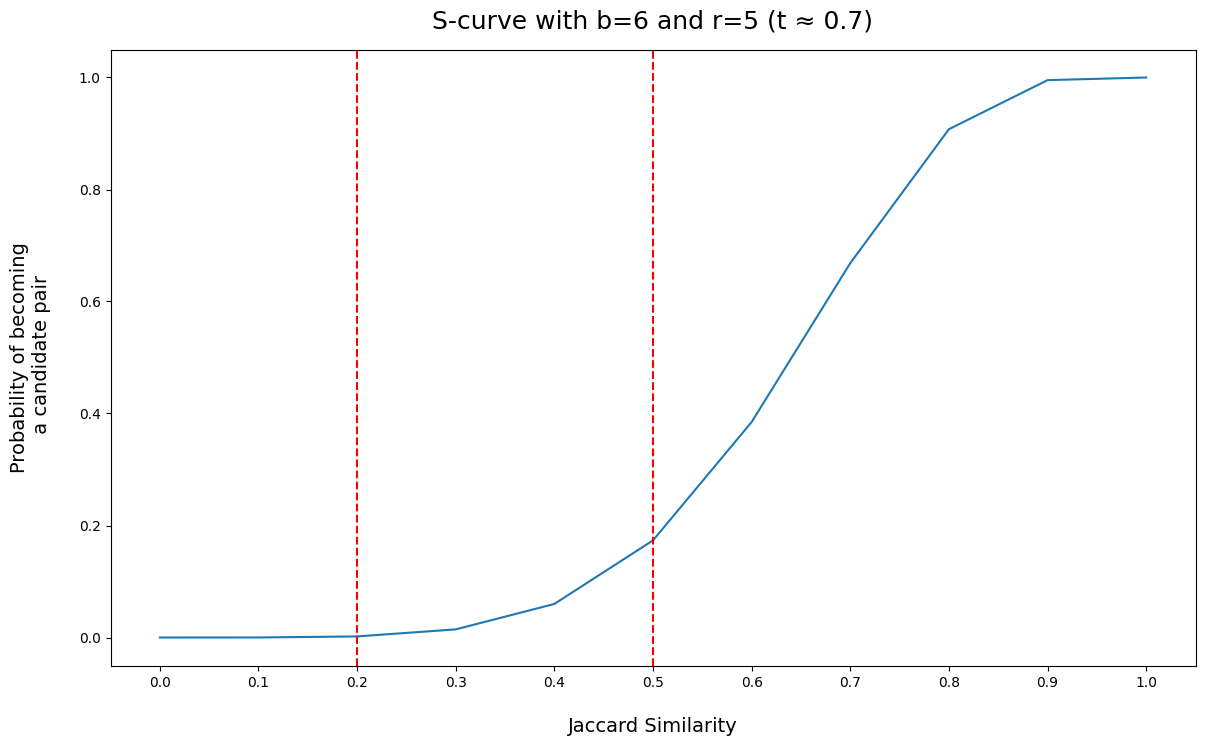

In [26]:
functions.s_curve(6, 5)

In [27]:
buckets = LSH(signature_matrix, 6, 5)

In [ ]:
similar_items = find_similar(buckets)

{0: 0, 0.2: 3504979.0, 0.5: 99553536.0, 1: 39891916.0}

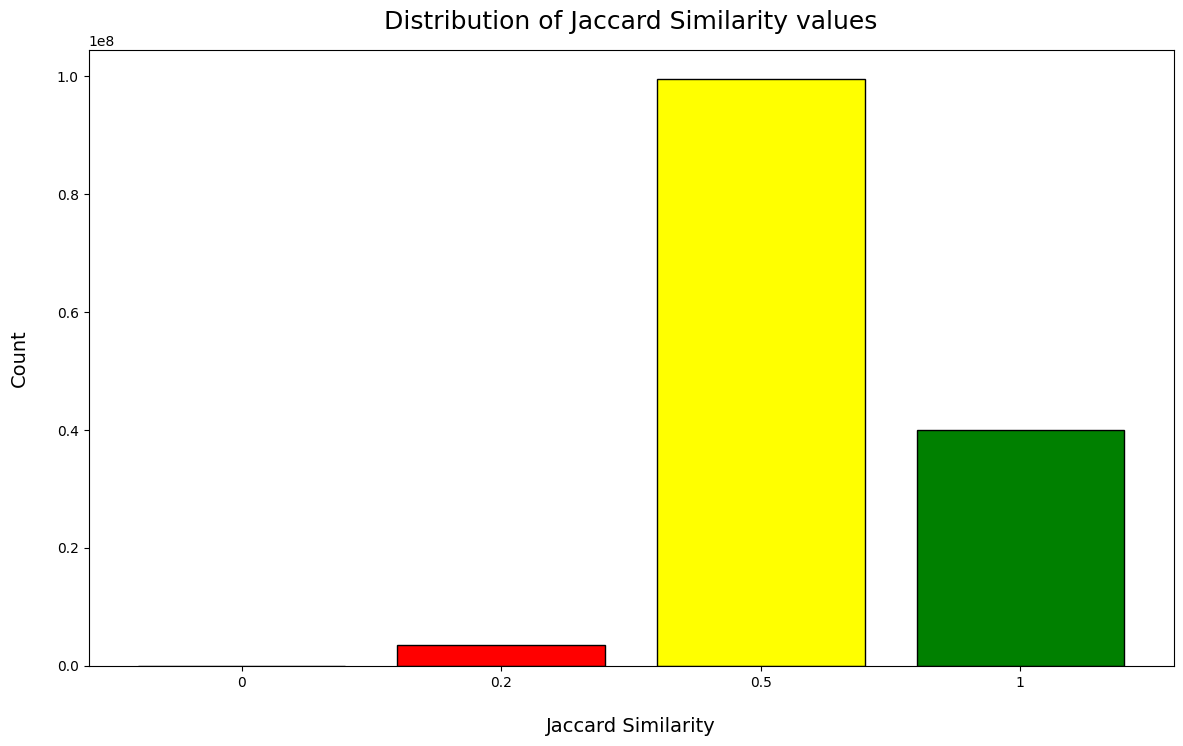

In [29]:
functions.plot_jaccard(similar_items, shingle_sets, jaccard_similarity)

With **t ≈ 0.7**, a small percentage of the pairs of customers has a *Jaccard Similarity* value of $0.2$ (*i.e. customers have only one shingle in common*) and the number of pairs with a similarity value of $0.5$ is *more than double* the one of the customers sharing *all the shingles*.

We therefore try to **increase** the threshold **t** with the aim of reducing the number of *dissimilar* pairs selected

### - Threshold: t ≈ 0.76 (b = 5, r = 6)

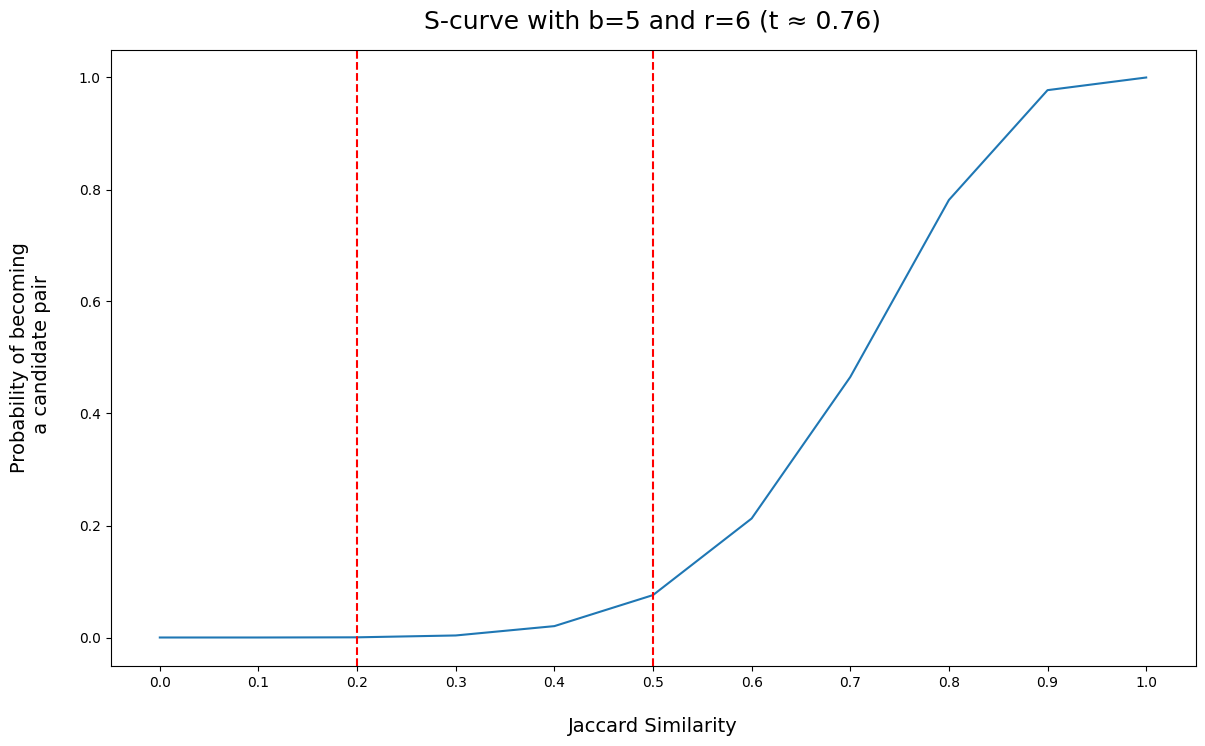

In [16]:
functions.s_curve(5, 6)

In [17]:
buckets = LSH(signature_matrix, 5, 6)

In [18]:
similar_items = find_similar(buckets)

{0: 0, 0.2: 0, 0.5: 64113642.0, 1: 39891916.0}

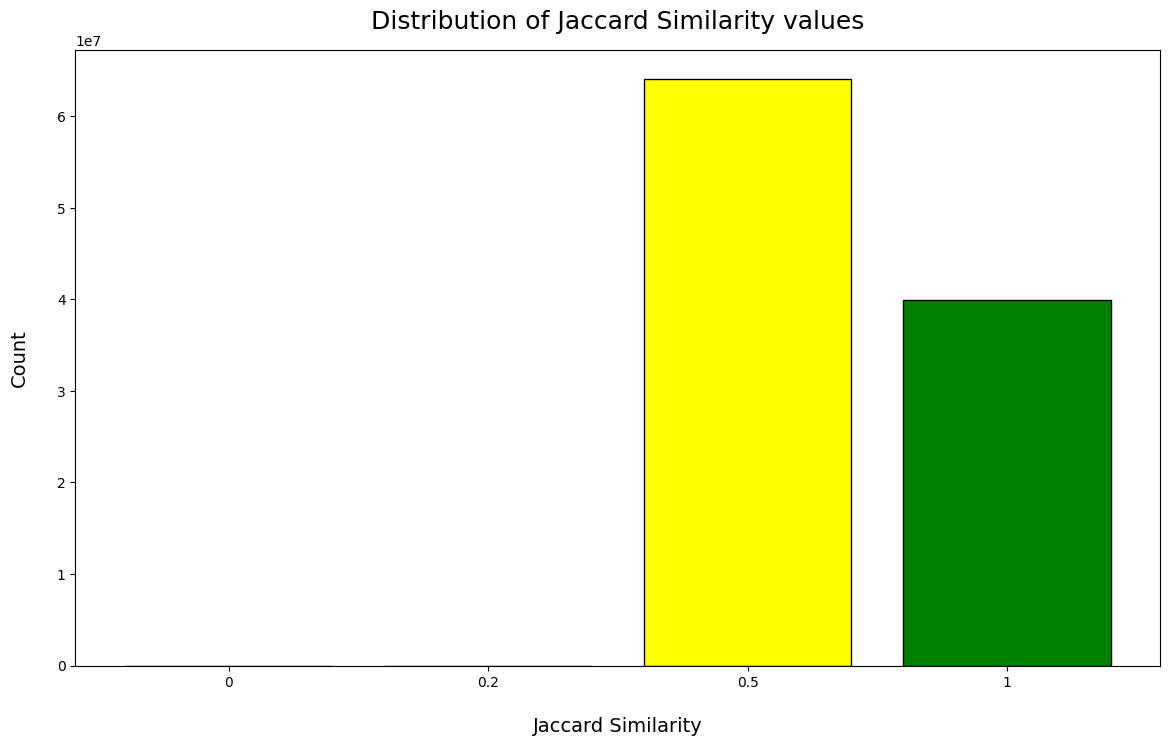

In [19]:
functions.plot_jaccard(similar_items, shingle_sets, jaccard_similarity)

With **t ≈ 0.76**, *no pair* exhibit a *Jaccard Similarity* value of $0.2$ and fewer pairs having *2 shingles in common* are selected.

We then try to **increase** the threshold **t** even further for exploratory purposes.

### - Threshold: t ≈ 0.9 (b = 3, r = 10)

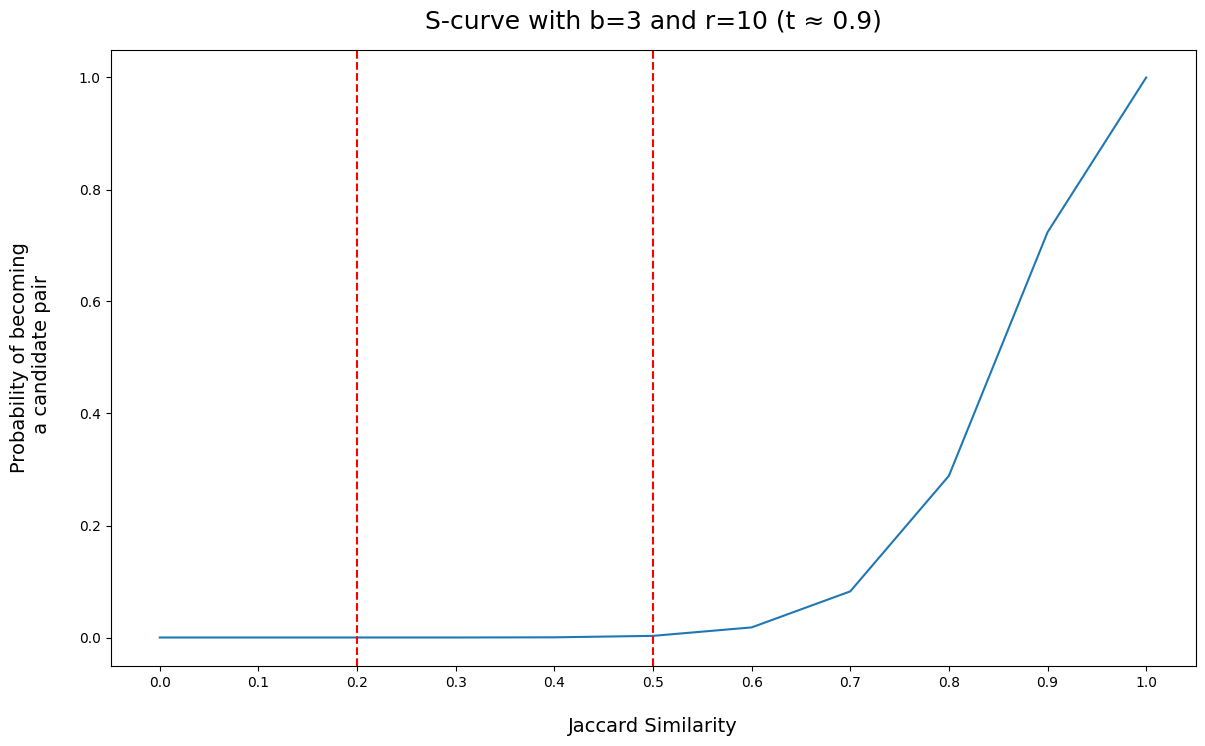

In [34]:
functions.s_curve(3, 10)

In [42]:
buckets = LSH(signature_matrix, 3, 10)

In [ ]:
similar_items = find_similar(buckets)

{0: 0, 0.2: 0, 0.5: 312604.0, 1: 39891916.0}

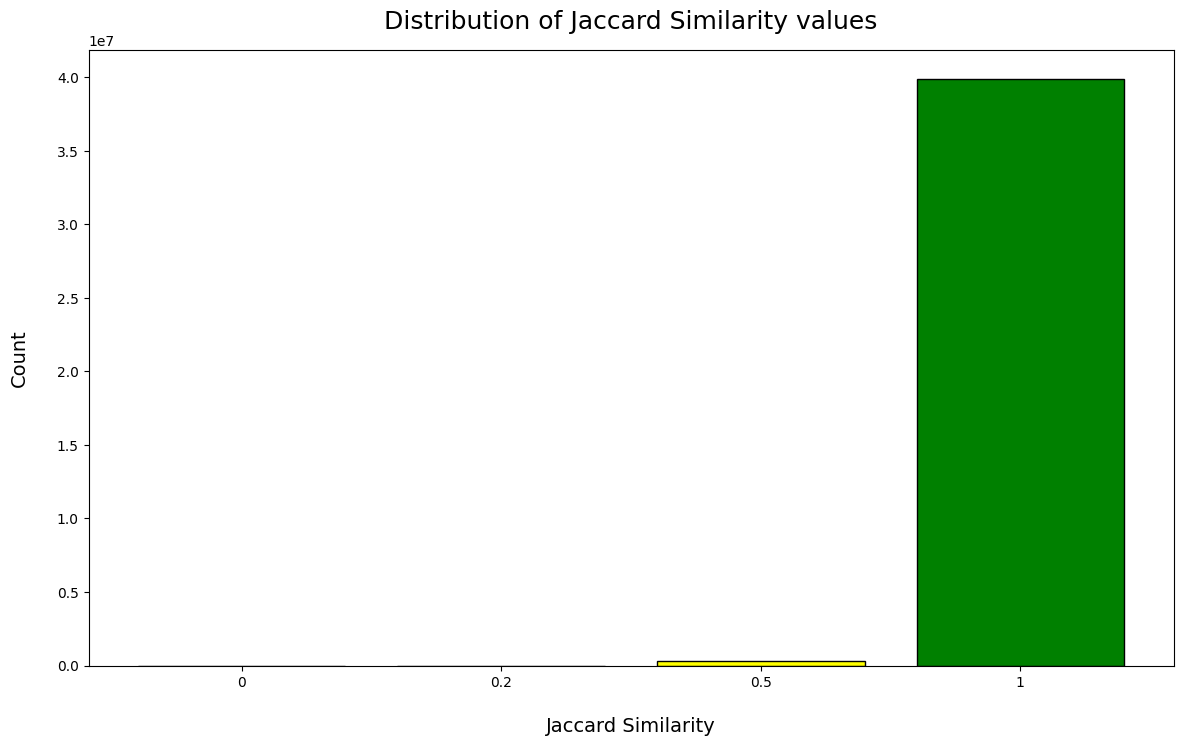

In [44]:
functions.plot_jaccard(similar_items, shingle_sets, jaccard_similarity)

### - Threshold: t ≈ 0.95 (b = 2, r = 15)

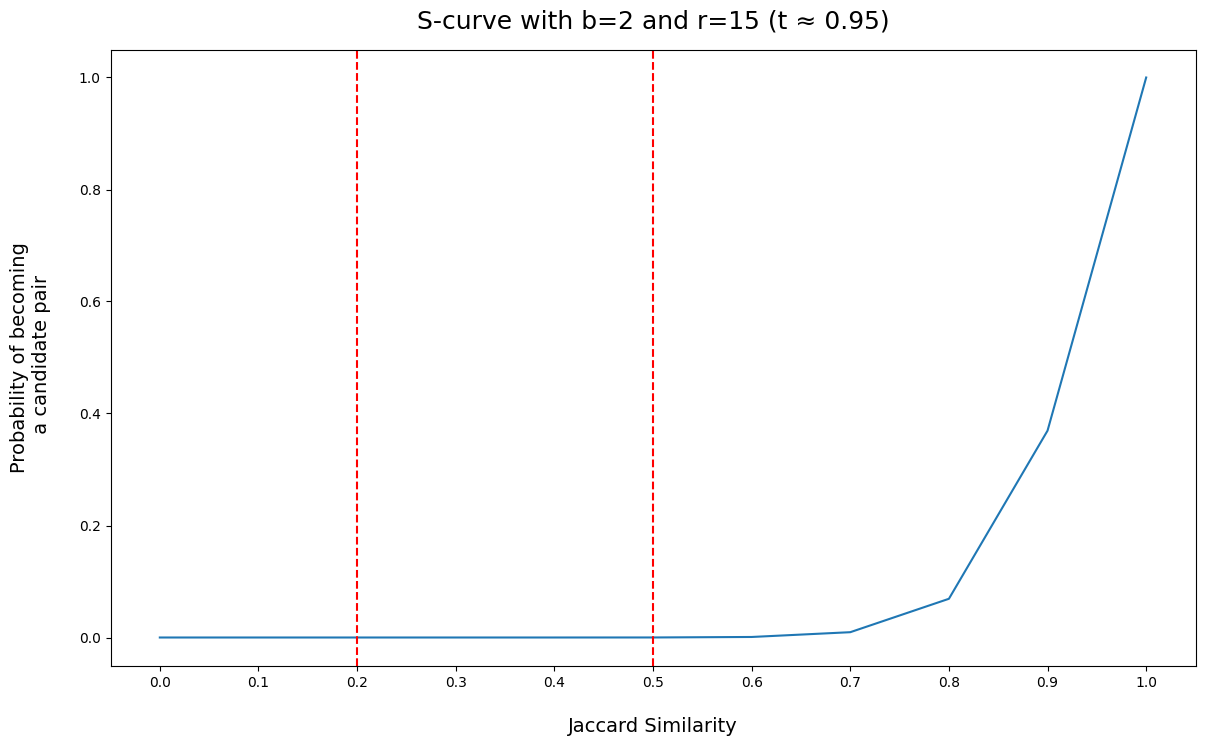

In [45]:
functions.s_curve(2, 15)

In [46]:
buckets = LSH(signature_matrix, 2, 15)

In [ ]:
similar_items = find_similar(buckets)

{0: 0, 0.2: 0, 0.5: 0, 1: 39891916.0}

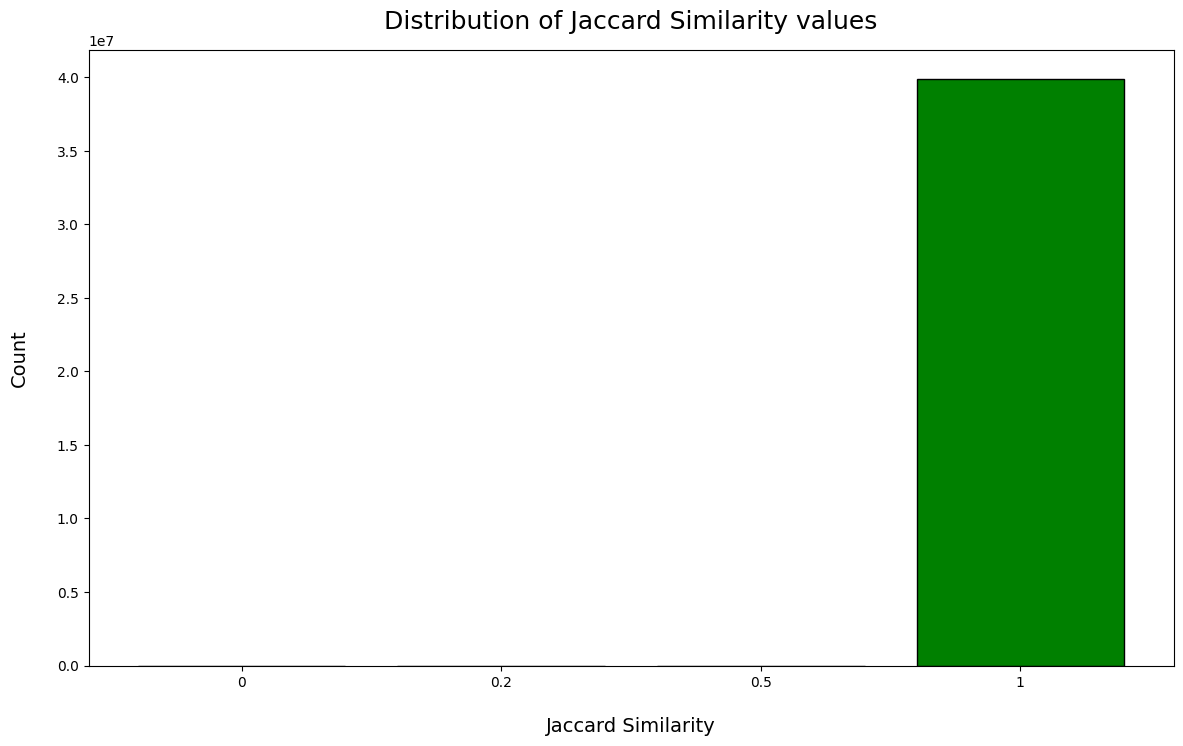

In [48]:
functions.plot_jaccard(similar_items, shingle_sets, jaccard_similarity)

When **t > 0.9**, the *Prob(Selected pair) vs Jaccard Similarity* curve **loses its characteristic S-shape** and almost only *pairs* having customers with *all shingles in common* are selected. This comes as a **red flag**, since the algorithm would be *significantly biased* towards pairs that are *identical* according to our shingling procedure (that are anyway selected, irrespectively of the threshold), neglecting *too many* possible *highly similar* customers.

After the parameter tuning procedure, the threshold **t ≈ 0.76** ($b=5$, $r=6$) is chosen, since it seems to provide a proper **tradeoff** between **false positive** (*no pairs with Jaccard Similarity < 0.5 are picked*) and **false negative** (*a fairly big amount of customers with Jaccard Similarity = 0.5 are still selected as candidate pairs*)

## 1.3 Locality Sensitive Hashing

We run the query for the dummy users provided, comparing each of them against the original dataset. The result will provide the **top-k** (if available) most similar users for each user in the query, where **k** is chosen to be $50$.

In [16]:
# Run LSH with the selected parameters
b = 5
r = 6

buckets = LSH(signature_matrix, b, r)

In [31]:
query_df = pd.read_csv('query_users.csv')

In [32]:
#ADDING CUSTOMER ID's
query_df['CustomerID'] = [i for i in range(200001, 200001+len(query_df))]
query_df = query_df.replace({"CustomerDOB":{'1/1/1800':0}})

#We create a new DF containing all rows with CustomerDOB NaNs or containing "1800-01-01".
missing_values_df = query_df[query_df.CustomerDOB == 0]
#We drop these 60K rows from the data, we will concat them later with the NaN values filled in.
query_df = query_df.drop(query_df[query_df.CustomerDOB == 0].index ,axis = 0)

#We create a dictionary to map every new ID with a randomly sampled date from the CustomerDOB column.
missing_values_df["New_Date"]= missing_values_df.CustomerID
new_dates = pd.DataFrame(sample(list(query_df.CustomerDOB),4),np.unique(missing_values_df.CustomerID)).to_dict()[0]
missing_values_df = missing_values_df.replace({"New_Date":new_dates})

#Some adjustments before concatenating again with the data
missing_values_df["CustomerDOB"] = missing_values_df["New_Date"]
missing_values_df.drop("New_Date", axis = 1, inplace = True)

#We update the data with the 60K that were dropped, but now without NaNs.
query_df = pd.concat([query_df,missing_values_df])

#CONVERT TO DATETIME OBJECT
query_df.CustomerDOB =  pd.to_datetime(query_df.CustomerDOB)
#FIXING MILLENIUM BUG
#query_df.drop(query_df[query_df.CustomerDOB == "1800-01-01"].index, axis = 0,inplace = True)
query_df.loc[query_df.CustomerDOB.dt.year > 2016, "CustomerDOB"] -= pd.offsets.DateOffset(years = 100)
#CREATE "AGE", WHICH IS MORE CONVENIENT
query_df["CustomerAge"] = ((pd.to_datetime("20160101", format = "%Y%m%d", errors = "ignore" ) - query_df.CustomerDOB) / np.timedelta64(1,"Y")).round()
query_df["CustomerAge"] = query_df["CustomerAge"].astype(int)

query_df.drop(['CustomerDOB', 'CustLocation', 'CustGender', 'TransactionDate', 'TransactionTime'], axis = 1, inplace = True)
query_df['TransactionAmount (INR)'] = query_df['TransactionAmount (INR)'].astype(int)
query_df.rename({'TransactionAmount (INR)': 'TransactionAmountAverage'}, axis=1 , inplace = True)
query_df['CustAccountBalance'] = query_df['CustAccountBalance'].astype(int)

query_df = query_df[['CustomerID', 'CustAccountBalance', 'TransactionAmountAverage', 'CustomerAge']]
query_df = query_df.sort_index()

In [33]:
query_df

,CustomerID,CustAccountBalance,TransactionAmountAverage,CustomerAge
0,200001,94695,65,37
1,200002,7584,6025,24
2,200003,7180,541,24
3,200004,56847,1000,29
4,200005,84950,80,21
5,200006,23143,303,34
6,200007,15397,20,39
7,200008,426,50,24
8,200009,4609,300,26
9,200010,6695988,299,45


In [78]:
top_k = 50

result = query(buckets, shingle_sets, query_df, shingles, b, r, top_k, perms, num_perms=30)

The query (taking as input the *pre-built MinHash* matrix for the original dataset) takes about 5 seconds to run for each user with the chosen parameters.

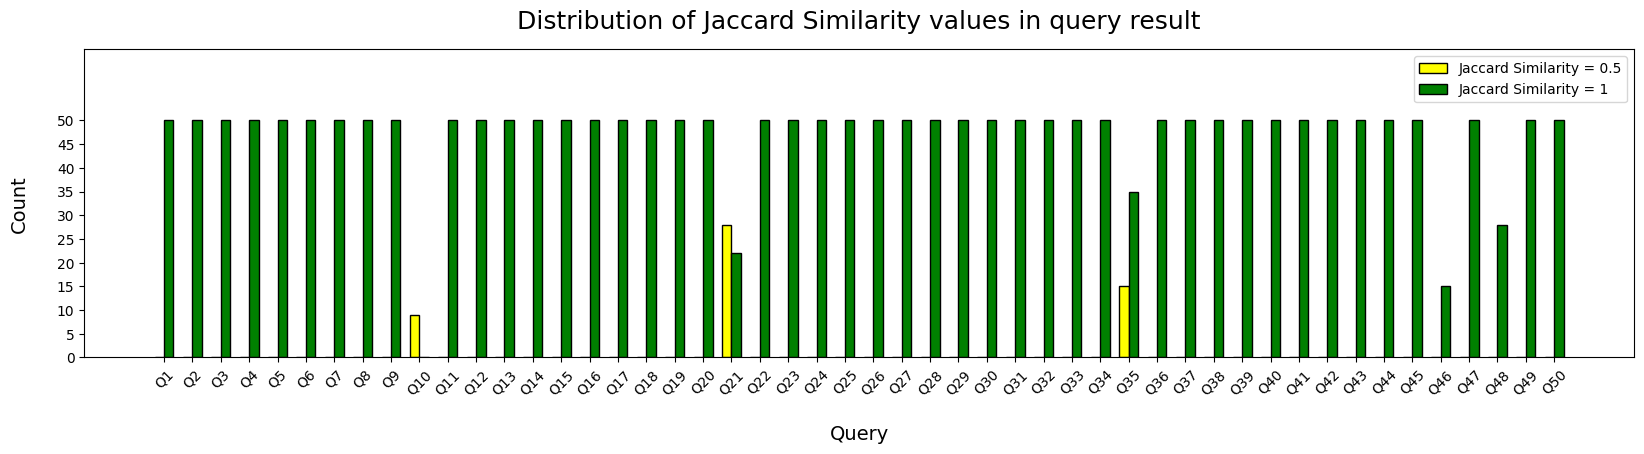

In [86]:
functions.plot_query(result)

A visual analysis of the results provides insights which are in line with the theoretical assumptions.

Most of the customers are paired with **K=50** clients *identical* (*Jaccard Similarity = 1*) according to the shingling procedure adopted. The choice of the threshold value determines what happens where there are *less than* **K** customers within the original dataset sharing *all the shingles* with the query user (which are guaranteed to be selected by algorithm design). With **t ≈ 0.76**, as expected, *no pair* of customers having *Jaccard Similarity < 0.5* are outputted; however, *not all the query customers* have **K** clients associated to them. In tuning the threshold, we made the assumption that for these customers the bank was ready to *miss out* on some *fairly similar* clients (**false negative**) in order to make sure *not to retrieve* any really dissimilar ones (**false positive**): in fact, the number of customers with *Jaccard Similarity* equal to $0.5$ and $1$ sums up to 50 for $Q21$ and $Q35$, whereas this is not the case for $Q10$, $Q46$ and $Q48$.

While the lack of clients with *Jaccard Similarity = 1* with $Q10$ implies their absence in the original dataset, having e.g. *zero* pairs with *Jaccard Similarity = 0.5* including $Q46$ doesn't mean there exist none. To verify it, we inspect the dataset, manually filtering for customers sharing *shingles* with $Q46$

$Q46$ shingles:

**Account Balance**: $1M<B<=5M$
**Average Transaction Amount**: $150<T<=300$
**Age**: $26<=A<=29$

In [84]:
# Customers sharing all the shingles: Jaccard Similarity = 1
df[(df["CustAccountBalance"]>1e6) & (df["CustAccountBalance"]<=5e6) & (df["TransactionAmountAverage"]>150) & (df["TransactionAmountAverage"]<=300) & (df["CustomerAge"]>=26) & (df["CustomerAge"]<=29)]

,CustomerID,CustAccountBalance,TransactionAmountAverage,CustomerAge
782,782,1006498,291,26
24338,24338,1059939,207,28
26010,26010,1241557,199,29
56523,56523,1104525,220,29
89574,89574,1576985,252,28
92887,92887,1007870,237,27
110408,110408,1530156,191,28
119431,119431,2538455,205,29
126431,126431,1548204,197,28
130725,130725,1267382,178,26


In [95]:
# Customers sharing only 2 shingles (Account Balance and Average Transaction Amount): Jaccard Similarity = 0.5
df[(df["CustAccountBalance"]>1e6) & (df["CustAccountBalance"]<=5e6) & (df["TransactionAmountAverage"]>150) & (df["TransactionAmountAverage"]<=300) & ((df["CustomerAge"]<26) | (df["CustomerAge"]>29))]

,CustomerID,CustAccountBalance,TransactionAmountAverage,CustomerAge
481,481,1083916,192,24
685,685,1473749,161,41
9417,9417,2862104,252,46
14500,14500,2284897,251,24
23167,23167,2400624,290,39
23445,23445,1967451,287,35
29836,29836,1934157,205,23
40224,40224,1349492,230,31
41067,41067,1111584,200,34
44453,44453,1257068,245,39


Even if there exists customers with *Jaccard Similarity = 0.5* (here we only show the results of one of the three possible combinations of pairs of variables: Account Balance and Average Transaction Amount), their number is likely to be *too small* for the *LSH* algorithm with the selected threshold to retrieve any of them.

The results respect the *theoretical tradeoff* that guided the choice of the *LSH* threshold: **the bank is missing out on few possible matches for a small number of customer, but it is not being proposed any undesired match at all!**

# 2. Grouping customers together!

### 2.1 Getting data + feature engineering

First we create a new dataframe in which we have the 7 recommended features and one row per Customer ID.

a) Number of transactions <br>
b) Number of transactions with a balance bigger than 100 USD <br>
c) Average amount of the transactions <br>
d) Average balance <br>
e) Average difference between the balance and the transaction amount for each customer (this is mainly known in the banking world as utilisation). <br>
f) Most common gender of the customer <br>
h) Most frequent location of the customer

In [17]:
new_features=pd.DataFrame(data.CustomerID)

#1 number of transactions
new_features['NumTransactions'] = data.groupby('CustomerID')['CustomerID'].transform('size')

#2 number of transactions greater than 100
trans_100 = data[data['TransactionAmount'] > 100*82].groupby('CustomerID')['TransactionAmount'].count().to_frame()
trans_100.rename({'TransactionAmount' : 'NumTransaction_greater100'}, axis = 1, inplace=True)
new_features = new_features.merge(trans_100, on='CustomerID', how='outer')
new_features['NumTransaction_greater100'] = new_features['NumTransaction_greater100'].fillna(0).astype(int)

#3 Average amount of the transactions
averages = data[['CustomerID', 'TransactionAmount']].groupby('CustomerID').mean().astype(int)
averages.rename({'TransactionAmount' : 'TransactionAverage'}, axis = 1, inplace=True)
new_features = new_features.merge(averages, on='CustomerID')

# 4 Average balance
new_features = new_features.merge(data[['CustAccountBalance', 'CustomerID']].drop_duplicates('CustomerID'))
new_features.rename({"CustAccountBalance":"BalanceAverage"}, axis = 1, inplace = True)
# 5 Utilisation
new_features['Utilisation'] = new_features['BalanceAverage'].astype(int) - new_features['TransactionAverage'].astype(int)

#6 Gender
new_features = new_features.merge(data[['CustGender', 'CustomerID']].drop_duplicates('CustomerID'))

#7 Location
new_features = new_features.merge(data[['CustLocation', 'CustomerID']].drop_duplicates('CustomerID'))
new_features = new_features.drop_duplicates(subset = ['CustomerID'])


new_features = new_features.sort_values(by="CustomerID")
new_features.set_index("CustomerID" , inplace = True)
new_features

,NumTransactions,NumTransaction_greater100,TransactionAverage,BalanceAverage,Utilisation,CustGender,CustLocation
CustomerID,,,,,,,
0,27,0,80,17819,17739,F,JAMSHEDPUR
1,12,4,9503,2270,-7233,M,JHAJJAR
2,11,0,940,17874,16934,F,MUMBAI
3,13,0,2537,866503,863966,F,MUMBAI
4,4,0,1606,6714,5108,F,NAVI MUMBAI
...,...,...,...,...,...,...,...
171282,1,0,726,218207,217481,M,THANE
171283,1,0,600,182889,182289,M,IMPERIA THANE WEST
171284,1,0,220,15037,14817,F,NEW DELHI


Then, we add another 20 variables:


- Customer Age

- Average Hour of Transaction (Mean Hour)
- Average time between transactions (Days,hours,minutes,seconds)
- Total Transaction Amount
- Quartiles of Average Balance
- Quartiles of Transaction
- Quartiles of Utilisation
- Max Transaction
- Min Transaction
- Average Balance per Location
- Average Transaction per Location
- Customer Score
- Target for Mortgage plans: above Q2 in Balance and between 30-45 years old.
- Target for Life Insurance: above Q3 in Balance and  more than 46 years old.
- Target for short term loans: below Q1 in Balance and between 23-29 years old.
- Target for Investment Account: above Q1 in Balance and between 23-29 years old.
- Age Intervals ≤22 (10,7%) , 23-25 (20,4%) , 26-29 (25,7%), 30-35 (22,5%) , 36-45 (14.1%) and ≥46 (7,2%).
- Average Balance Bands
- Average Transaction Bands
- Percentage of transactions higher than 6000

#### Customer Age

By looking at the data we see that 75% of the customers have less than 34 years old, and 90% have less than 42. This essentially means that this bank targets a young audience, and therefore we will focus more on the "younger" intervals in order to fit better the variables distribution. ≤22 (10,7%) , 23-25 (20,4%) , 26-29 (25,7%), 30-35 (22,5%) , 36-45 (14.1%) and ≥46 (7,2%).

In [18]:
#ADD AGE COLUMN
new_features = pd.merge(new_features,data.groupby("CustomerID").CustomerAge.mean(),left_index=True, right_index=True)

#### Age Intervals

In [19]:
#CREATE AGE INTERVALS
age_intervals = functions.age_intervals(new_features["CustomerAge"], ["≤ 22" , "23-25" , "26-29" , "30-35" , "36-45" ,"≥ 46"])
#ADD NEW VARIABLE TO DATAFRAME
new_features["Age_Range"] = age_intervals

#### Average Hour of Transaction

In [20]:
new_features["AverageTransactionHour"] = data.groupby("CustomerID").TransactionHour.mean().astype(int)

#### Average time between transactions

In [21]:
#Range of the dates in the data.
avg_times_btw_transactions = data.groupby("CustomerID").aggregate({'TransactionDateTime':["max", "min", "count"]})
avg_times_btw_transactions = (avg_times_btw_transactions.TransactionDateTime['max'] - avg_times_btw_transactions.TransactionDateTime['min']) / (avg_times_btw_transactions.TransactionDateTime['count']-1)
avg_times_btw_transactions.fillna(pd.Timedelta(seconds=0),inplace = True)
new_features["Average_Time_Between_Transactions"] = round(avg_times_btw_transactions,"s")/ np.timedelta64(1, 's')

#### Total Transaction Amount

In [22]:
new_features["TotalTransactionAmount"] = data.groupby('CustomerID')['TransactionAmount'].sum().to_frame().rename({'TransactionAmount' : 'TotalTransactionAmount'}, axis = 1)

#### Maximum Transaction Amount

In [23]:
new_features["MaxTransactionAmount"] = data.groupby('CustomerID')['TransactionAmount'].max()

#### Minimum Transaction Amount

In [24]:
new_features["MinTransactionAmount"] = data.groupby('CustomerID')['TransactionAmount'].min()

#### Average Transaction Bands

In [25]:
new_features['AvgTransaction_Range'] = new_features.loc[:,'TransactionAverage'].transform(lambda x: functions.transaction_int(x)).astype(int)

#### Quantiles of Average Transaction

In [26]:
new_features["TransactionQuartiles"] = functions.quantiles(new_features.TransactionAverage)

#### Average Transaction per Location

In [27]:
new_features["AverageTransactionAtLocation"] = new_features["CustLocation"]
new_features = new_features.replace({"AverageTransactionAtLocation": new_features.groupby("CustLocation").TransactionAverage.mean().astype(int).to_dict()})

#### Percentage of transactions over 6,000 INR

In [28]:
num_over_6000 = data[data['TransactionAmount'] >= 6000].groupby('CustomerID')['TransactionAmount'].count().to_frame()
num_over_6000.rename({'TransactionAmount' : 'NumTransaction_greater6000'}, axis = 1, inplace = True)
num_over_6000 = num_over_6000.merge(data[['CustomerID']], on = 'CustomerID', how = 'outer')
num_over_6000.fillna(0, inplace=True)

total = data.groupby('CustomerID')['TransactionID'].count().to_frame()
num_over_6000 = num_over_6000.merge(total, on = 'CustomerID', how = 'outer')
num_over_6000.rename({'TransactionID' : 'NumTransaction'}, axis = 1, inplace = True)
num_over_6000['Percentagetrans_over6000'] = round(100 * num_over_6000['NumTransaction_greater6000']/num_over_6000['NumTransaction'], 2)
num_over_6000.drop_duplicates(inplace = True)

new_features = new_features.merge(num_over_6000[['CustomerID', 'Percentagetrans_over6000']], on = 'CustomerID', how = 'outer')
new_features.set_index("CustomerID",inplace = True)

#### Average Balance Bands

In [29]:
new_features['Balance_Range'] = new_features.loc[:,'BalanceAverage'].transform(lambda x: functions.balance_int(x)).astype(int)

#### Quantiles of Average Balance

In [30]:
new_features["BalanceQuartiles"] = functions.quantiles(new_features.BalanceAverage)

#### Average Balance per Location

In [31]:
new_features["AverageBalanceAtLocation"] = new_features["CustLocation"]
new_features = new_features.replace({"AverageBalanceAtLocation": new_features.groupby("CustLocation").BalanceAverage.mean().astype(int).to_dict()})

#### Quantiles of Utilisation

In [32]:
new_features["UtilisationQuartiles"] = functions.quantiles(new_features.Utilisation)

#### Customer Score

We decided to create a customer score based on some of their most important features:

- AverageAccountBalance:  <br>
- AverageTransaction: <br>
- N° transactions: Log(n° transactions)\3 = points <br>
<i>Why? ---> If someone has made 1 transaction has 0 points. If someone has made 538 transaction (max value) has 2 points, which seems reasonable, because the bank might charge per transaction, so they value this aspect as well, but probably not as much as the other 2 (balance and transaction average).</i>
<p>
<center><b>Customer score = AverageAccountBalance Points + TransactionAverage Points + N° transaction points</b>



In [33]:
score1 = [np.log(i)/3 for i in new_features.NumTransactions]
score2 = [int(new_features.BalanceQuartiles[i][1]) for i in range(len(new_features))]
score3 = [int(new_features.TransactionQuartiles[i][1]) for i in range(len(new_features))]
new_features["CustomerScore"] = ((np.array(score1) + np.array(score2) + np.array(score3))).round(1)

#### Commercially oriented variables

As we assumed when creating new IDs, the Account balance variable is clearly not changing through the year, which  means that this data is from a specific moment in time, making very difficult to estimate the net worth of a particular individual, as we don't know what exactly what is this data (amount at the moment of the first transaction, their average monthly balance, the yearly balance...etc).

We decided to make a plausible assumption, namely, that this is the <b >average monthly data, estimated at the moment of their last transaction</b>. This assumption together with the fact that the monthly average salary in India in 2016 was around <a href="https://economictimes.indiatimes.com/news/economy/finance/average-per-capita-income-in-last-4-yrs-higher-at-nearly-rs-80000/articleshow/65322914.cms" target="_top">6,700 INR</a>, we consider that those customers above Q2 (>13.711 monthly) are active workers and with a monthly salary that is higher than average, hence attractive targets for specific financial products. With this setup, from a commercial banking perspective we have come up with three different targets:

#### Target for Mortgage plans
Those above Q2 in Balance and between 30-45 years old.

In [34]:
new_features["MortgageTarget"] = pd.concat([pd.DataFrame(new_features.index[(new_features.BalanceAverage <= 13711) | (new_features.CustomerAge <= 29) | (new_features.CustomerAge > 45)]).set_index("CustomerID").assign(label= 0),pd.DataFrame(new_features.index[(new_features.BalanceAverage > 13711) & (new_features.CustomerAge > 29)& (new_features.CustomerAge < 46)]).set_index("CustomerID").assign(label= 1)]).sort_values(by = "CustomerID").label

#### Target for Life insurance
Those above Q3 in Balance and with more than 45 years old.

In [35]:
new_features["LifeInsuranceTarget"] = pd.concat([pd.DataFrame(new_features.index[(new_features.BalanceAverage <= 49497) | (new_features.CustomerAge <= 45)]).set_index("CustomerID").assign(label = 0),pd.DataFrame(new_features.index[(new_features.BalanceAverage > 49497) & (new_features.CustomerAge > 45)]).set_index("CustomerID").assign(label = 1)]).sort_values(by = "CustomerID").label

#### Target for Short Term loan
Those with an income less than Q1 and between 23 and 29 years old.

In [36]:
new_features["ShortTermLoanTarget"] = pd.concat([pd.DataFrame(new_features.index[(new_features.BalanceAverage >= 3337) | (new_features.CustomerAge >= 29)]).set_index("CustomerID").assign(label = 0),pd.DataFrame(new_features.index[(new_features.BalanceAverage < 3337) & (new_features.CustomerAge < 29)]).set_index("CustomerID").assign(label = 1)]).sort_values(by = "CustomerID").label

#### Target for Broker/Investment account
Target for open a Broker account Those with an income more than Q1 and between 23 and 29 years old.

In [37]:
new_features["InvestmentAccountTarget"] = pd.concat([pd.DataFrame(new_features.index[(new_features.BalanceAverage <= 3337) | (new_features.CustomerAge >= 29)]).set_index("CustomerID").assign(label = 0),pd.DataFrame(new_features.index[(new_features.BalanceAverage > 3337) & (new_features.CustomerAge < 29)]).set_index("CustomerID").assign(label = 1)]).sort_values(by = "CustomerID").label

## 2.2. Choose features!

### Principal Component Analysis (PCA)

#### Encoding categorical features: creating dummy variables

In [38]:
new_features['Age_Range'] = new_features['CustomerAge'].transform(lambda x: functions.age_int(x)).astype(int)
new_features = new_features.replace({"CustGender": {"T": "M"}})
new_features_pca = pd.get_dummies(new_features, columns = ['CustGender'])
new_features_pca["BalanceQuartiles"] = [int(new_features.BalanceQuartiles[i][1]) for i in range(len(new_features))]
new_features_pca["TransactionQuartiles"] = [int(new_features.TransactionQuartiles[i][1]) for i in range(len(new_features))]
new_features_pca["UtilisationQuartiles"] = [int(new_features.UtilisationQuartiles[i][1]) for i in range(len(new_features))]
new_features_pca.drop("CustLocation", axis = 1, inplace = True)

#### Normalizing data

We use StandardScaler to standardize the dataset’s features into the unit scale (mean = 0 , variance = 1) which is a requirement for the optimal performance of the algorithm. Otherwise, the variables that are in a higher scale, would be predominant when computing PCA, which is not desirable as it doesn’t represent the real variability of the data

In [39]:
scaler = StandardScaler()
scaled_data= StandardScaler().fit_transform(new_features_pca)

#### PCA

In [40]:
pca=PCA()
new_features_pca_ = pca.fit(scaled_data)
new_features_pca_ = pca.transform(scaled_data)

#### Visualization of the principal components

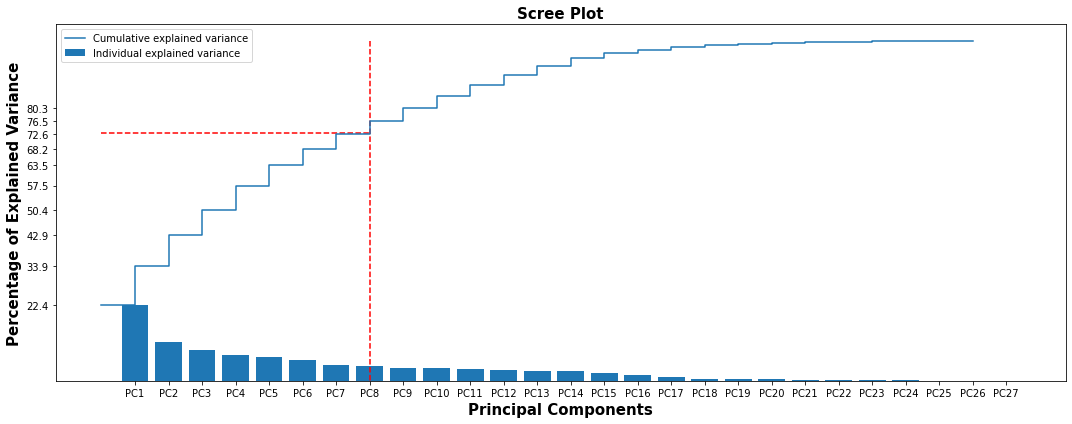

In [41]:
per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
cum_sum_exp = np.cumsum(per_var)
functions.scree_plot(per_var,cum_sum_exp)

The first 8 principal components retain 72.6% of the total variability of the data.

In [42]:
np.set_printoptions(formatter={'float_kind':'{:f}'.format}) #convert exponential notation into float.
pd.DataFrame(np.cumsum(pca.explained_variance_ratio_)).T

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,0.224468,0.339524,0.429767,0.504598,0.575736,0.636152,0.683246,0.727064,0.766224,0.803759,...,0.98189,0.987935,0.991911,0.994624,0.996936,0.99888,0.999767,1.0,1.0,1.0


Create new Dataframe with first 8 principal components

In [43]:
col_names = ['PC_'+str(i) for i in range(1, 28)]
data_reduced_df = pd.DataFrame(data = new_features_pca_ , columns = col_names)
data_reduced_df = data_reduced_df.iloc[:, 0:8]
data_reduced_df.head()

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8
0,-1.338033,-1.035762,3.347574,0.186264,1.051868,1.562153,1.443838,0.553556
1,2.611095,4.461079,-2.361300,-0.924598,-0.868332,2.744599,-0.687794,-1.791402
2,0.179426,-0.217339,3.461391,-0.550276,1.138691,-0.017359,0.065123,-0.294532
3,4.161616,-1.736852,0.294139,-0.714214,1.921296,0.942481,-1.145248,1.066842
4,-0.286872,0.306559,1.877299,-1.338493,1.691856,-0.283509,-0.142256,-0.768851


## 2.3. Clustering!

### MapReduce K-means clustering algorithm implementation

We take advantage of the **Spark** *cluster computing framework* to set up the **K-means** *MapReduce* pipeline. We create a *Resilient Distributed Datasets* (**RDD**) collecting all the customers data and apply the *K-means* algorithm iteratively according to the *MapReduce* framework.

In [7]:
df_reduced = data_reduced_df
df_points = [tuple([round(x,2) for x in r]) for r in df_reduced.to_numpy()]

In [26]:
# Creating Spark Context
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark import SparkContext

spark = SparkSession.builder.master("local[1]").appName('Kmeans').getOrCreate()
sparkcontext = SparkContext.getOrCreate()
rdd = sparkcontext.parallelize(df_points)

# Reduce function
def reduce_f(x): return (np.mean(list(x), axis=0).tolist(), x)

In [44]:
def kmeans_pyspark(rdd, reduce_f, k, points, max_iters=50):

    # Initialize centroids: randomly select k points
    centroids = sample(points, k)

    # Run MapReduce
    for i in range(max_iters):

        # Map: associate each point to the closest centroid
        map = rdd.map(lambda x: (centroids[np.argmin([np.sum((np.array(x)-np.array(c))**2) for c in centroids])], x))

        # Reduce: find new centroid for each cluster
        reduce = map.groupByKey().mapValues(reduce_f).values().collect()

        centroids = [tuple(x[0]) for x in reduce]
        clusters = [list(x[1]) for x in reduce]

    return centroids, clusters

### 2.3.2. Find optimal number of clusters

### Method 1: Elbow method (using Inertia)

We run the *K-means clustering* with different values of **K**; for each execution, we plot the *Sum of Squared Distances* (**Inertia**) of all data points to their closest centroid and select as optimal **K** the value where the **Inertia** suddenly drops (*Elbow* point)

In [4]:
# Compute inertia
def inertia(points, centroids):

    out = 0

    for point in points:
        out+=min([np.sum((np.array(point)-np.array(c))**2) for c in centroids])

    return out

### Method 2: Silhouette analysis

We run the *K-means clustering* with different values of **K**; for each execution, we compute the **Average Silhouette Coefficient** over all the data points and select as optimal **K** the value where this is *maximized*. The **Silhouette Coefficient** for a data point $i$ is defined as: $$S(i) = \frac{b(i)-a(i)}{max\{a(i),b(i)\}$$ with $a(i) = \frac{1}{|C_I|-1} \sum_{j \in C_I, i \ne j} d(i,j)$ being the *mean distance between $i$ and all the other data points in the same cluster $C_I$*, and $b(i) = min_{J \ne I} \frac{1}{|C_J|} \sum_{j \in C_J} d(i,j)$ being the *smallest mean distance of $i$ to all points in any other cluster*


### K-means clustering

In [5]:
# Set hyperparameters
max_clusters = 10
max_iters = 50

In [ ]:
inertia_values = []
silhouette_values = [0]
kmeans_results = {}

# Run K-means for different values of k
for k in range(1, max_clusters+1):

    centroids, clusters = kmeans_pyspark(rdd, reduce_f, k, df_points, max_iters)

    clust_id = {}
    for i in range(k):
        for point in clusters[i]:
            clust_id[point] = i

    inertia_values.append(inertia(df_points, centroids))
    if k>1: silhouette_values.append(silhouette_score(df_points, [clust_id[point] for point in df_points]))

    kmeans_results[k] = {"centroids": centroids, "clusters": [clust_id[point] for point in df_points]}

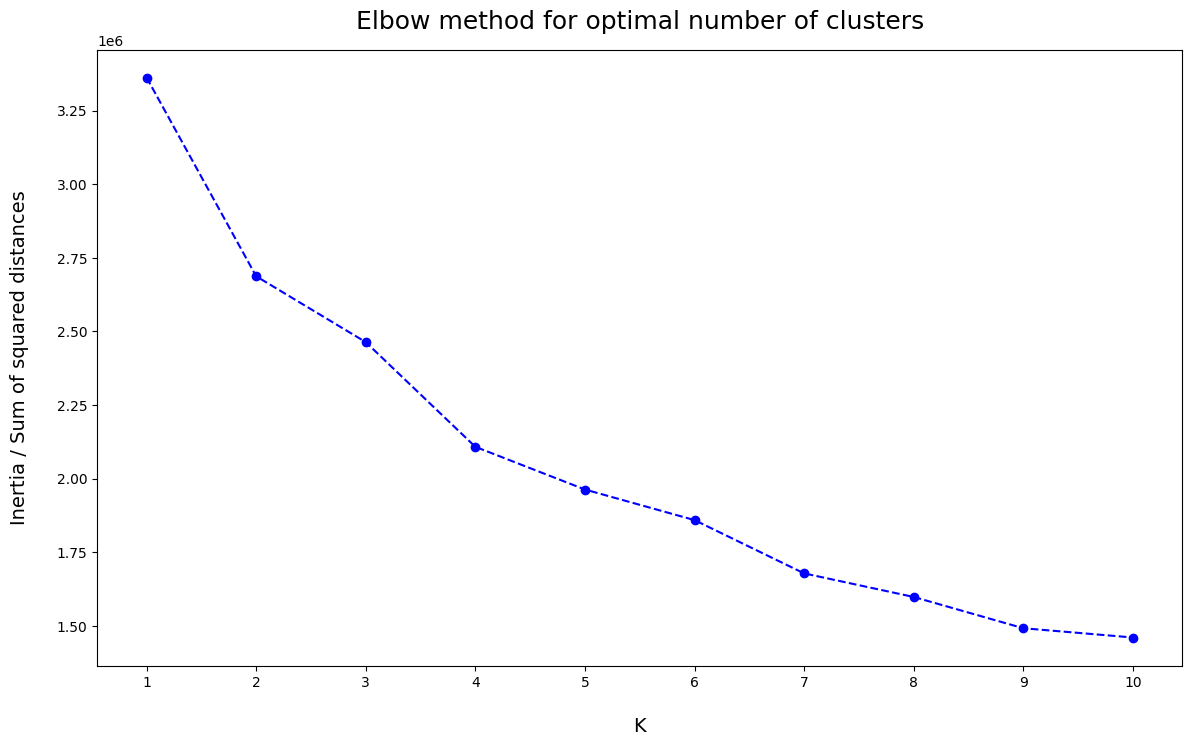

In [46]:
functions.elbow_method(inertia_values, max_clusters)

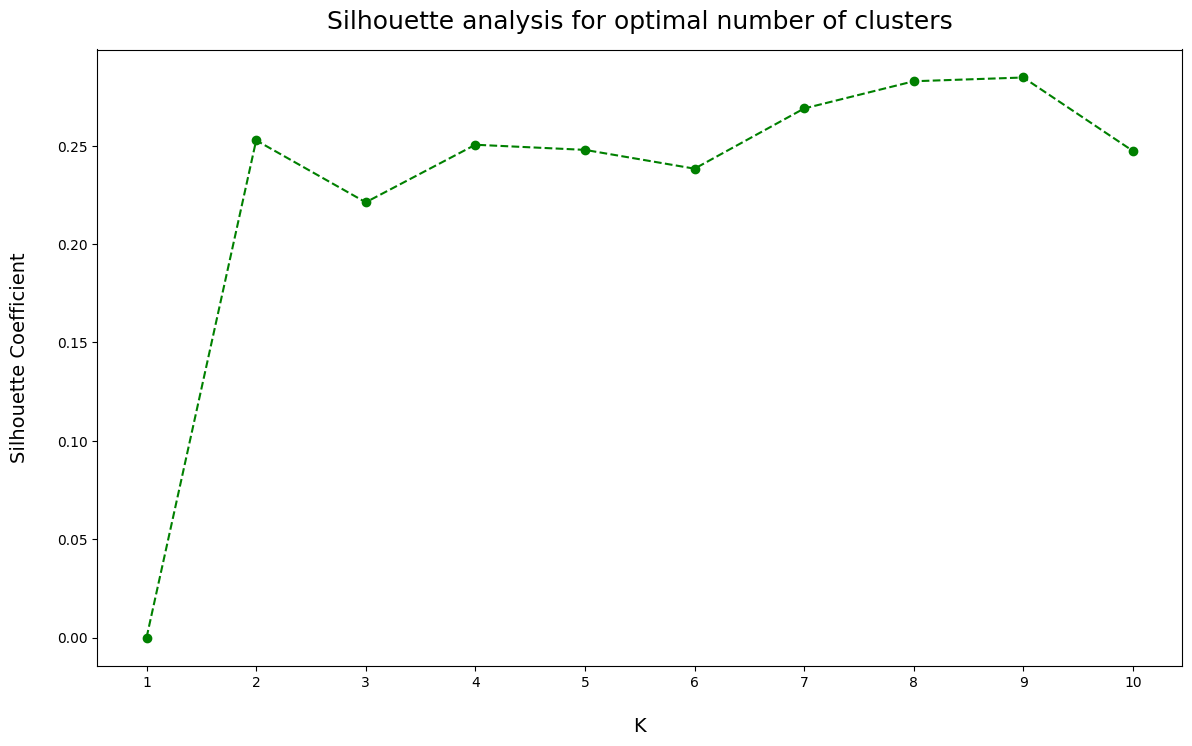

In [47]:
functions.silhouette_analysis(silhouette_values, max_clusters)

According to the two methods, we pick as $4$ optimal number of clusters. At  **K=4**, the **Inertia** plot exhibits an *elbow*, while the **Silhouette** plot shows a *local* maximum. Other choices at higher **K** values could be also viable, but we prefer to stick with a rather *small* number of clusters to hopefully obtain somehow *interpretable* results.

### K-means++ clustering

In [ ]:
inertia_values = []
silhouette_values = [0]
kmeans_results = {}

for k in range(1, max_clusters+1):

    kmeans_model = KMeans(n_clusters = k)
    kmeans_model.fit(df_reduced)

    centroids = kmeans_model.cluster_centers_
    clusters = kmeans_model.labels_

    inertia_values.append(kmeans_model.inertia_)
    if k>1: silhouette_values.append(silhouette_score(df_points, clusters))

    kmeans_results[k] = {"centroids": centroids, "clusters": clusters}

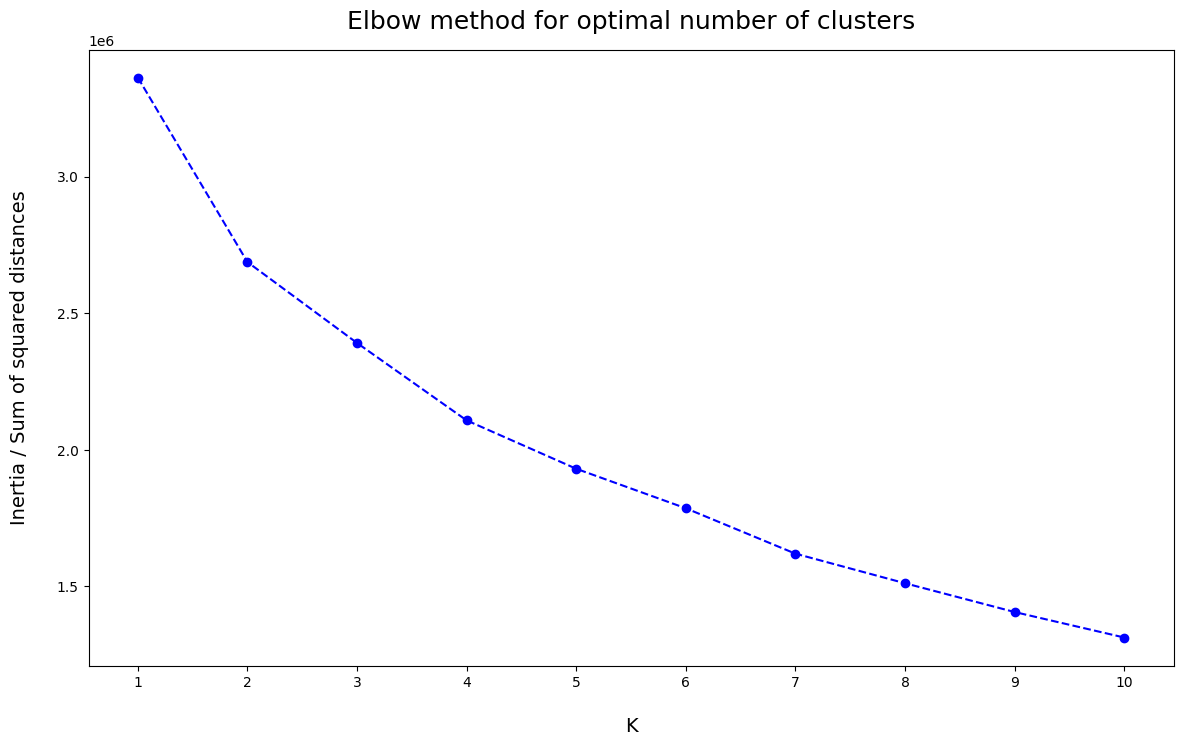

In [50]:
functions.elbow_method(inertia_values, max_clusters)

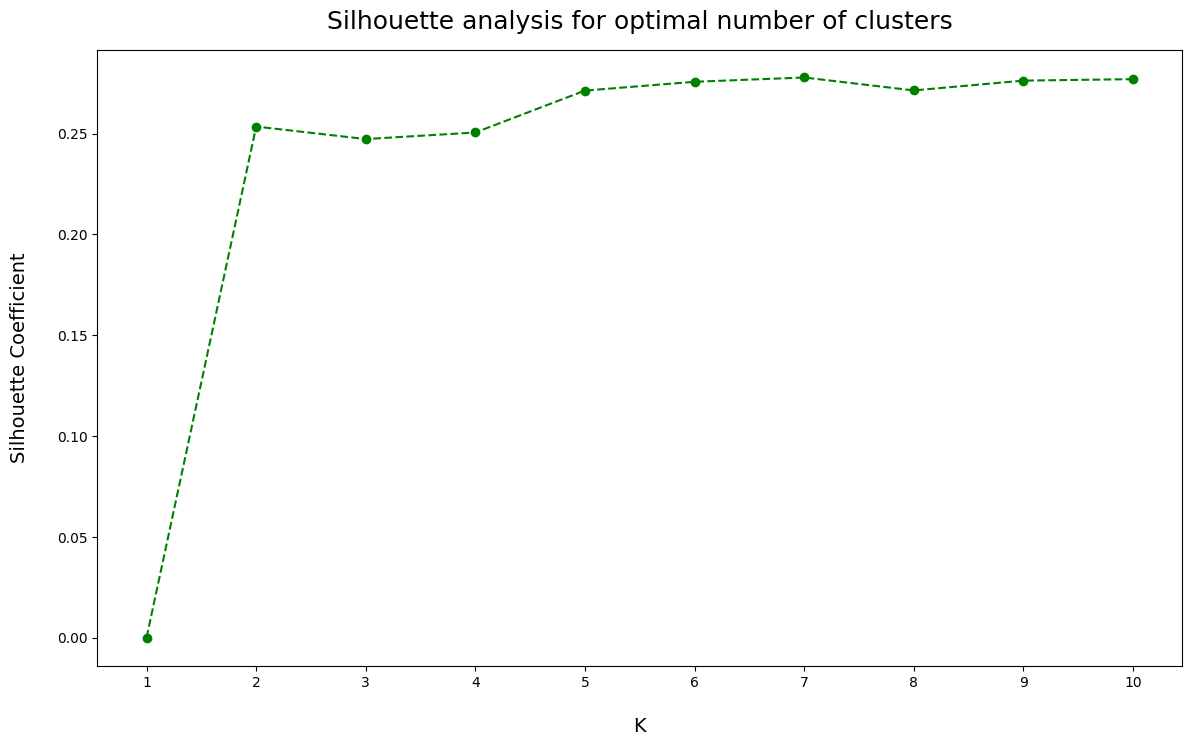

In [55]:
functions.silhouette_analysis(silhouette_values, max_clusters)

The graphs of both the methods for the **K-means++** clustering algorithm exhibit a *much smoother* behaviour than the ones obtain with the *vanilla* version (*random initialization*). Even if **K=4** is not a *local* maximum in the **Silhouette** plot (whose values distribution is anyway rather *flat*), it still represents an *elbow* point in the **Inertia** one.

## 2.4. Analysing results!

Although there are other variables that add value to the understanding of the obtained clusters, we choose the three most important ones: <b>Account Balance, Age and Utilisation.

In [ ]:
#add  new column to the data that includes the cluster to which belongs a customer.
new_features["Cluster"] = kmeans_results[4]["clusters"]
customers = new_features
#for age, we choose 4 bins such that the original population is uniformly distributed over them (25% of original population each)
customers['BinnedAge'] = pd.cut(x=customers['CustomerAge'], bins=[0, 24, 28, 34, 150],labels=['<=24', '25-28', '29-34','>=35'])
#plotting the tables
df1 = round(100*customers.groupby('Cluster')["BalanceQuartiles"].value_counts(normalize = True).unstack().fillna(0),2)
df2 = round(100*customers.groupby('Cluster')["BinnedAge"].value_counts(normalize = True).unstack().fillna(0),2)
df3 = round(100*customers.groupby('Cluster')["UtilisationQuartiles"].value_counts(normalize = True).unstack().fillna(0),2)

#### Balance

In [48]:
df1

,Cluster,Q1,Q2,Q3,Q4
0,0,73.00,26.96,0.03,0.00
1,1,0.00,41.08,35.76,23.16
2,2,0.03,5.46,42.19,52.32
3,3,10.02,13.85,22.51,53.62


#### Age

In [49]:
df2

,Cluster,<=24,25-28,29-34,>=35
0,0,23.80,21.34,32.90,21.96
1,1,40.37,51.92,6.37,1.34
2,2,1.26,1.53,41.28,55.93
3,3,10.58,18.11,25.14,46.16


#### Utilization

In [50]:
df3

,Cluster,Q1,Q2,Q3,Q4
0,0,69.29,29.69,1.03,0.00
1,1,1.33,38.64,36.52,23.51
2,2,0.34,5.89,41.01,52.76
3,3,26.60,8.63,16.67,48.10


### Balance Quartiles

- In Cluster 0, 3/4 of the customers belong to the first quartile, the remaining percentage belongs to the second quartile. This suggests that <b>customers in Cluster 0 have less money than average</b>.
- In Cluster 1, 40% of the customers are in the second quartile, 36% in third quartile and 23% in fourth quartile. This suggests that overall, <b>customers in Cluster 1 have the average amount of money</b>.
- In Cluster 2, 52% of the customers are in the fourth quartile, 42% in third quartile and the small remaining part in second quartile. This suggests that <b>customers in Cluster 2 have all more money than average</b>.
- In Cluster 3, 54% of the customers are in last quartile, 23% in third quartile and the rest of the customers is almost equally distributed among the other two intervals. This suggests that <b>customers in Cluster 3 have more money than average.</b>

### Customer Age

- In Cluster 0, the customers are almost equally distributed among the four intervals of age. This means that <b>customers in cluster 0 were not classified by their age, but rather other attributes</b>.
- In Cluster 1, 52% of customers are between 25 and 28 years old, while the others are younger than 24. This suggests that the majority of <b>customers in Cluster 1 are young people in their twenties</b>.
- In Cluster 2, 56% of customers are older than 35, while the others are between 29 and 34 years old. This suggests that the majority of <b>customers in Cluster 2 are people in their thirties</b>.
- In Cluster 3, 46% of customers are more than 35 years old, 25% are between 29 and 34 years old, almost 20% are between 25 and 28, while the remaining 10% is younger than 24. This suggests that the majority of <b>customers in Cluster 3 are people in their early thirties or late twenties</b>.

### Utilisation Quartiles

- In Cluster 0, almost 70% of the customers are within the first quartile, and the remaining 30% in the second quartile. This suggests that <b>customers in Cluster 0 tend to spend a lot (of even more) of what they have in their account</b>.
- In Cluster 1, almost 40% of the customers are in the second quartile, other 40% in the third quartile and the remaining 23% in fourth quartile. This suggests that <b>customers in Cluster 1 tend to spend less than they have, they are money savers</b>.
- In Cluster 2, around 50% of the customers are within the fourth quartile, 40% in third and the small remaining part in second quartile. This suggests that <b>customers in Cluster 2 have more money than average and/or spend less than what they have</b>.
- In Cluster 3, approximately 50% of the customers are in the last quartile, 1/4 are in first quartile and the remaining part is divided between second and third quartiles with a ratio 1:2. Customers in Cluster 3 have more money than average but a non-negligible percentage of them has lower utilisation values, which may suggest that they spend more, but the values are quite uniform, <b>customers in cluster 3 were not classified by their utilisation, but rather other attributes</b>.


Moreover, in order to understand better the clusters, we suggest these other 3 variables:

- Nº of people: All clusters have around 50K and 60K people but cluster 3, that has 7K.
- Gender: The distribution of male and female customers is almost identical through the four clusters.
- Transaction Quartiles: Here we basically understand why <b>cluster 3 is separated from the rest, they not only have more money than average, but they also move it a lot more than other clusters.

In [ ]:
df6 = round(100*customers.groupby('Cluster')["TransactionQuartiles"].value_counts(normalize = True).unstack().fillna(0),2)
df5 = round(100*customers.groupby('Cluster')["CustGender"].value_counts(normalize = True).unstack().fillna(0),2)
df4 = new_features.Cluster.value_counts().sort_index().to_frame().rename({"Cluster": "Nº people"}, axis = 1)

#### N° Customers

In [56]:
df4

,Nº people
0,57617
1,57436
2,48797
3,7437


#### Gender

In [57]:
df5

,Cluster,F,M
0,0,20.10,79.90
1,1,31.14,68.86
2,2,26.11,73.89
3,3,26.19,73.81


#### Transaction

In [58]:
df6

,Cluster,Q1,Q2,Q3,Q4
0,0,38.05,28.31,21.50,12.13
1,1,26.27,29.89,26.34,17.50
2,2,12.02,19.18,31.25,37.55
3,3,0.01,0.00,0.01,99.97


## Further conclusions

We really believe that these clusters make sense because they fit very well from a commercial point of view:
- Cluster 0 is a potential target for short term loans (less money than, average, high expenditure).
- Cluster 1 is a potential target for an Investment/Broker account (young people with more money than average and also money savers).
- Cluster 2 is a potential target for Mortgage plans(mid-age people with more money than average and money savers).
- Cluster 3 is a potential target for Life Insurance and Private Pension plans (older people with much more money than average).

## Clustering algorithm performance

We decided to measure our clustering performances by computing the Calinski-Harabasz Index and the Davies-Bouldin Index.

In [32]:
X = data_reduced_df
CHscore = []
DBscore = []
for k in range(2,11):

    clusters = kmeans_results[k]['clusters']   #storing cluster labels
    customers['Cluster'] = clusters.tolist()   #appending them to the dataframe with the information about customers
    labels = customers.iloc[:,28]              #last column of the customers dataframe is the labels column
    CHscore.append(sklearn.metrics.calinski_harabasz_score(X, labels)) #compute Calinski Harabasz score and append to list
    DBscore.append(sklearn.metrics.davies_bouldin_score(X, labels)) #compute Davies Bouldin score and append to list

The first index is also called Variance Ratio Criterion. It represents the ratio of the sum of inter-cluster dispersion and the sum of intra-cluster dispersion for all clusters. The higher the index is, the denser and further away from one another are the clusters.

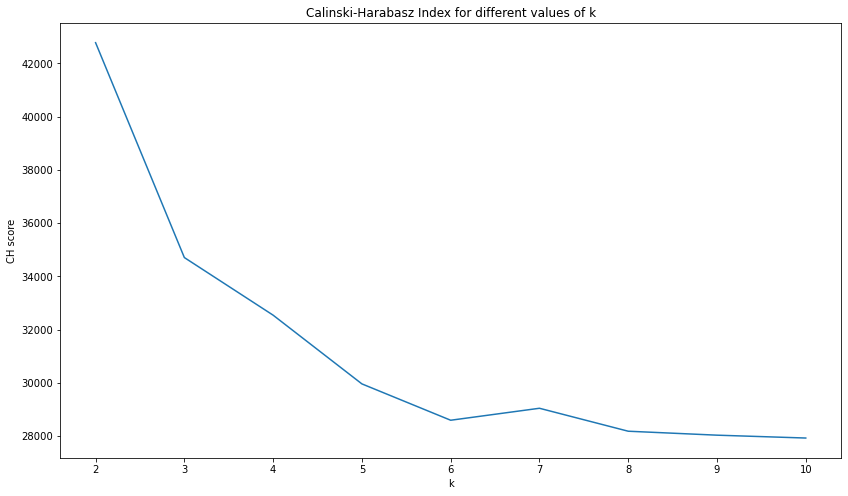

In [38]:
f = plt.figure()
plt.plot(range(2,11), CHscore)
plt.xlabel('k')
plt.ylabel('CH score')
f.set_figwidth(14)
f.set_figheight(8)
plt.title('Calinski-Harabasz Index for different values of k')
plt.show()

In general, we would like to select the number of clusters **K** that *maximizes* the Calinski-Harabasz Index. The plot shows that the index value is maximal at **K=2**; however, when this index exhibits such a behaviour (being maximized at **K=1** or **K=2** for high dimensional data), it is common practice to select as optimal value a *local* maximum point: for our data, it appears to be **K=7**.

The second index represents the similarity between clusters. Similarity is obtained comparing the distance between the clusters and the size of the clusters. A low Davies-Bouldin Index is related to more separated clusters, hence to better performances.

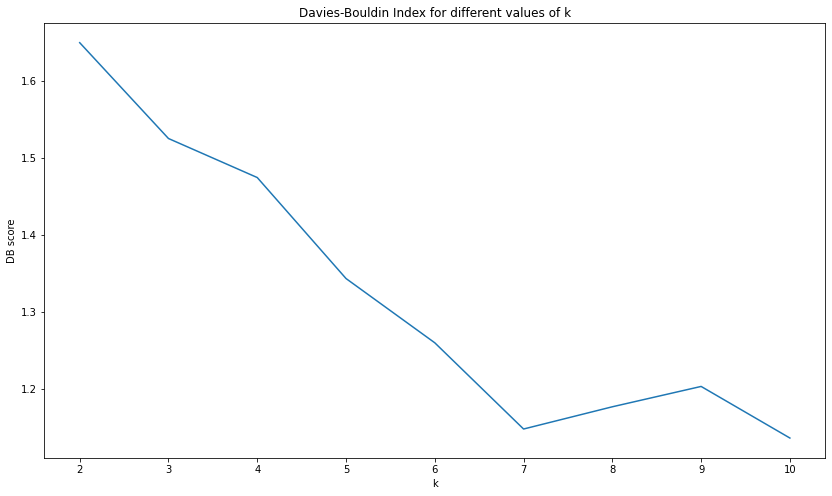

In [37]:
f = plt.figure()
plt.plot(range(2,11), DBscore)
plt.xlabel('k')
plt.ylabel('DB score')
f.set_figwidth(14)
f.set_figheight(8)
plt.title('Davies-Bouldin Index for different values of k')
plt.show()

The optimal number of clusters according to the Davies-Bouldin Index should be the **K** value at which the index is *minimized*: also this second metric appears to be suggesting that **K=7** would actually be the best choice for our data.

Although both the indexes suggest **K=7** to be the optimal number of clusters to select, our analysis highlighted that having a smaller number of clusters allows for a much easier interpretability of the results, which might be desirable from an economical perspective in the banking industry.

# Algorithmic Question

In order to understand if having $G$ guards is enough to enforce the restrictions, it is convenient to retrieve the time interval for which each entrance should be opened and then compute the **maximum number of overlapping intervals** (i.e. the maximum number of simultaneously open entrances).

The problem can then be split into **two subtasks**:

1. Retrieving all the time intervals *left* and *right* endpoints
2. Computing $max(\; n\_overlapping\_intervals)$

To solve $subtask_1$, we keep a dictionary $ends$ mapping each *entrance* to the index of its time interval *right endpoint* (when the last student enter through that specific entrance and the assigned guard can therefore leave the spot). We iterate over the array of entrances, where the $i$*-th* element corresponds to the entrance that has been assigned to the $i$*-th* student to enter the university:

* if $array[i]$ is not in $ends$: **the entrance appears for the first time**, so we mark the position in the array as *"left and right endpoint"* **"lr"** and set the *right endpoint* for the entrance to be $-i$ (i.e. coinciding with the left endpoint $i$. The minus sign state that the interval has *zero length*) $\rightarrow$ $array[i] = "lr"; \; ends[x] = -i$
* **otherwise**, we store the *previous right endpoint* $prev$ of the entrance, set it to be *i* and mark the position in the array as *"right endpoint"* **"r"** $\rightarrow$ $prev = ends[x]; \; ends[x] = i; \; arr[i] = "r"$. Then:
    * if the *previous right endpoint* **did not coincide** with the *left endpoint* ($prev>0$), we mark the corresponding position in the array to *"not an endpoint"* **""** $\rightarrow$ $arr[prev] = ""$
    * **otherwise**, we mark the corresponding position in the array ($-prev$) to *"left endpoint"* **"l"** $\rightarrow$ $arr[-prev] = "l"$

We will now have an array of *time intervals endpoints*. Since the original array of entrances was **sorted by time** in ascending order, this array will be sorted as well.

To solve $subtask_2$, and therefore provide an answer to the original problem, we iterate over the array of *endpoints*, keeping a counter for the *numbers of guards* needed at each time step ($curr\_guards$) and storing the *maximum number of guards* among all the steps ($max\_guards$). It should be noticed that there is *no need to know to which entrance each time interval endpoint belongs*, since we are only interested in the **maximum number of overlapping intervals**.

For each element $mark$ of the array:
* if $mark=="l"$ or $mark=="lr"$, **a new guard is needed to monitor the new entrance**: *current guards counter increases* $\rightarrow$ $curr\_guards += 1$
* elif $mark=="r"$, **a guard can close the entrance and leave the spot**: *current guards counter decreases* $\rightarrow$ $curr\_guards -= 1$
* **update the max counter** $\rightarrow$ $max\_guards = max(max\_guards, curr\_guards)$
* if $mark=="lr"$, **the guard that just opened the new entrance can close it and leave the spot right away**: *current guards counter decreases* $\rightarrow$ $curr\_guards -= 1$

In the end, compare $max\_guards$ with the input number of guards available $G$ to provide the final answer.

**Running-time complexity**: $O(M)$, with $M$ = number of students

In [96]:
def restrictions():

    # Input parsing
    N, M, G = map(int, input().strip().split())
    arr = list(map(str, input().strip().split()))

    print("Input:\n")
    print(N, M, G)
    print(" ".join(arr))
    print()
    print("Output:\n")

    # Dictionary of indexes of intervals right endpoints
    ends = {}

    # Iterate over the array of entrances assigned to the students
    for i in range(M):

        # entrance assigned to i-th student
        x = arr[i]

        # if first appearance of x entrance: i = interval left endpoint
        if x not in ends:

            # set right endpoints index of x interval to -i (minus sign to state that it coincides with left endpoint)
            ends[x] = -i

            # mark position in original array as "left and right endpoint"
            arr[i] = "lr"

        # otherwise: i = interval right endpoint
        else:

            # store previous right endpoint index of x
            prev = ends[x]

            # set right endpoint index of x interval to i
            ends[x] = i

            # mark position in original array as "right endpoint"
            arr[i] = "r"

            # if previous right endpoint did not coincide with the left endpoint (prev>0), mark corresponding position to "not an endpoint"
            # otherwise, mark corresponding position (-prev) to "left endpoint"
            if prev > 0:
                arr[prev] = ""

            else:
                arr[-prev] = "l"

    # Iterate over the marked array and return the max number of overlapping intervals
    # (i.e. number of guards needed to respect university restrictions)
    max_guards = 0
    curr_guards = 0

    for mark in arr:

        # if mark=="l" or mark=="lr", a new guard is needed to monitor the new entrance: current guards counter increases
        if mark == "l" or mark == "lr": curr_guards += 1

        # if mark=="r", a guard can close the entrance and leave the spot: current guards counter decreases
        elif mark == "r": curr_guards -= 1

        # update max guards counter
        max_guards = max(max_guards, curr_guards)

        # if mark=="lr", the guard that just opened the new entrance can close it and leave the spot right away: current guards counter decreases
        if mark == "lr": curr_guards -= 1

    # Return whether having G guards is enough to respect the restrictions
    return "YES" if G >= max_guards else "NO"

In [97]:
# Input 1
print(restrictions())

Input:

4 5 1
1 1 3 3 3

Output:

YES


In [98]:
# Input 2
print(restrictions())

Input:

2 5 1
1 2 1 2 2

Output:

NO
